## Recurrence Neural Networks Notebook

### Description:

This notebook aims to implement a **Recurrence Neural Network** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **Recurrence Networks** are capable of forecasting both stationary and non stationary series

### Recurrence Networks brief introduction

# COMPLETE


In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import itertools
from kerastuner.engine.hyperparameters import HyperParameters

# COMPLETE WITH PACKAGES FOR RECURRENCE

F:\anacondaPython\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from ipykernel import kernelapp as app


### Some useful functions -> COMPLETE WITH MORE IF NEEDED AND DELETE ONES NOT NEEDED

In [31]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

#Ploting a single time series
def plot_series(serie,title,xlabel,ylabel):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(serie)
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    #plt.ylim([0, 2])
    plt.show()
 
def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=0,y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#split both training and test datasets into X and y, data and targets
def train_test(train_data,test_data):
    X_train = train_data.values[:,:-1]
    y_train = train_data.values[:,-1]

    X_test = test_data.values[:,:-1]
    y_test = test_data.values[:,-1]

    return X_train, y_train, X_test, y_test
    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors


def train_RNN(train_series,test_series, n_input, n_features, n_epochs,in_activation,LSTM_unit_n):
    scaler = MinMaxScaler()
    scaler.fit(train_series)
    scaled_train_series = scaler.transform(train_series)
    scaled_testtest_series = scaler.transform(test_series)
    
    generatorTrain = TimeseriesGenerator(scaled_train_series, scaled_train_series, length=n_input, batch_size=1)
    generatorTest = TimeseriesGenerator(scaled_testtest_series, scaled_testtest_series, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(LSTM(LSTM_unit_n, activation=in_activation, input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    model.fit(generatorTrain,epochs=n_epochs)
    
    
    
    last_train_batch = scaled_train_series[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)

    test_predictions = []

    first_eval_batch = scaled_train_series[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test_series)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_predictions = scaler.inverse_transform(test_predictions)
    test_series['prodict Adj close'] = true_predictions
    #test_USD_CAD.plot(figsize=(14,5),)
    plot_series(test_series,'Blue is the Expected, orange is the forecast','Month','value')
    return model


def train_RNN_with_Error(train_series,test_series, n_input, n_features, n_epochs,in_activation,LSTM_unit_n):
    scaler = MinMaxScaler()
    scaler.fit(train_series)
    scaled_train_series = scaler.transform(train_series)
    scaled_testtest_series = scaler.transform(test_series)
    
    generatorTrain = TimeseriesGenerator(scaled_train_series, scaled_train_series, length=n_input, batch_size=1)
    generatorTest = TimeseriesGenerator(scaled_testtest_series, scaled_testtest_series, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(LSTM(LSTM_unit_n, activation=in_activation, input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    model.fit(generatorTrain,epochs=n_epochs)
    
    loss_per_epoch = model_A_A.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    
    last_train_batch = scaled_train_series[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)

    test_predictions = []
    
    first_eval_batch = scaled_train_series[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
    for i in range(len(test_series)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_predictions = scaler.inverse_transform(test_predictions)
    test_series['prodict Adj close'] = true_predictions
    #test_USD_CAD.plot(figsize=(14,5),)
    plot_series(test_series,'Blue is the Expected, orange is the forecast','Month','value')
    return model

### Importing the series and differenciating in order to get stationary behavior

# NOTE:

Feel free to pick just one to implement the code. After the code if ready and good, we can simply repeat for the others.
I would suggest pick one that is "diff".

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

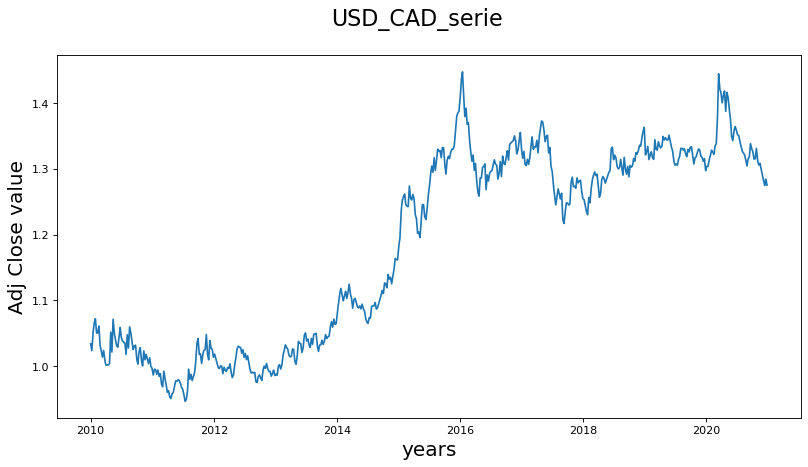

In [4]:
plot_series(USD_CAD_serie,'USD_CAD_serie','years','Adj Close value')

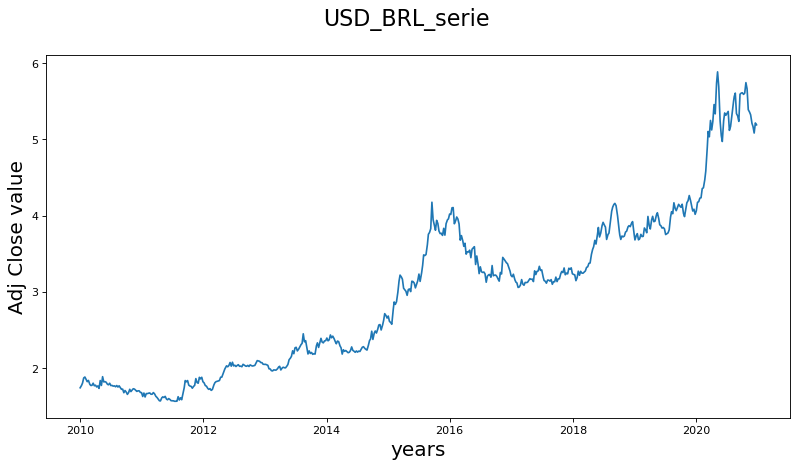

In [5]:
plot_series(USD_BRL_serie,'USD_BRL_serie','years','Adj Close value')

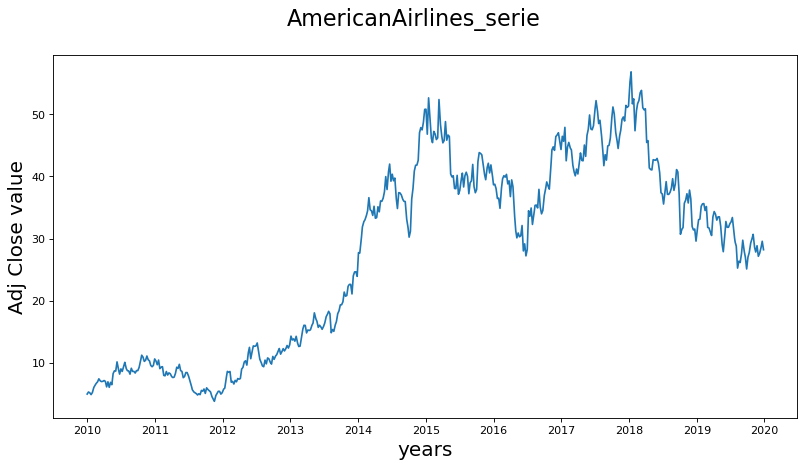

In [6]:
plot_series(AmericanAirlines_serie,'AmericanAirlines_serie','years','Adj Close value')

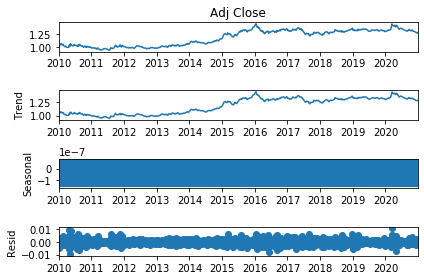

In [7]:
results = seasonal_decompose(USD_CAD_serie['Adj Close'])
results.plot();

In [8]:

train_USD_CAD,test_USD_CAD = train_test_split(USD_CAD_serie[:575],test_size = 0.30, shuffle =False)
train_USD_BRL,test_USD_BRL = train_test_split(USD_BRL_serie[:575],test_size = 0.30, shuffle =False)
train_A_A,test_A_A = train_test_split(AmericanAirlines_serie[:523],test_size = 0.30, shuffle =False)
 

#Let's take a look into the test series
print(test_USD_CAD.head())

#Let's just take a look into the dataframe.
test_USD_CAD.head()

            Adj Close
Date                 
2011-02-07    0.98988
2011-02-08    0.98851
2011-02-09    0.98714
2011-02-10    0.98577
2011-02-11    0.98440


,Adj Close
Date,
2011-02-07,0.98988
2011-02-08,0.98851
2011-02-09,0.98714
2011-02-10,0.98577
2011-02-11,0.98440


## Hyperparameter Search

Hard coding the hyperparameter search since I don't have a score function and the loss of the neural network is changing while it is being trained.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 3ms/step - loss: 0.0201
Epoch 2/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 3/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 4/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 5/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 6/100
390/390 [=================

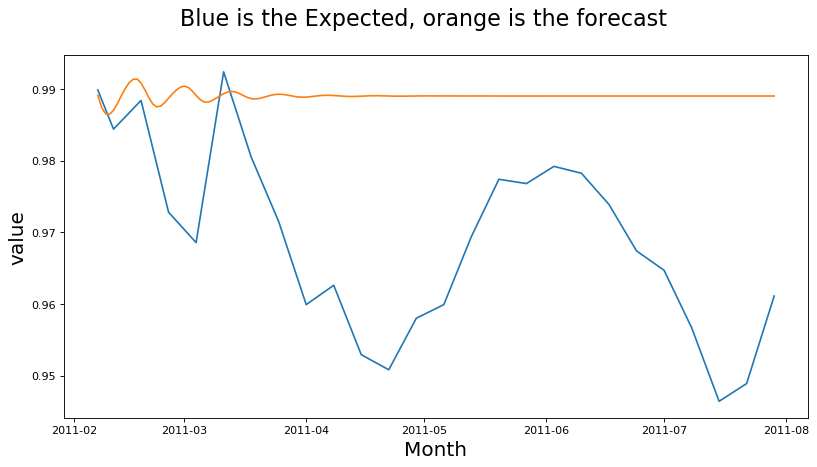

In [9]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'relu',100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 3s 4ms/step - loss: 0.0128
Epoch 2/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 3/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 4/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0017
Epoch 5/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 6/100
390/390 [===============

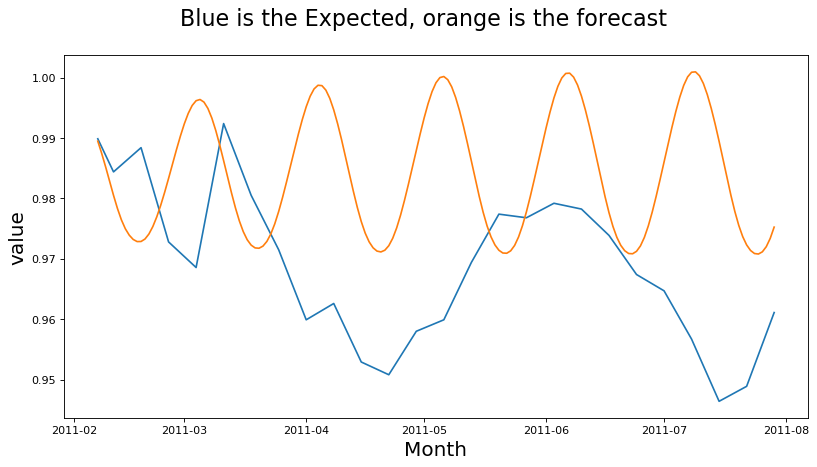

In [10]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'tanh',100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 [==============================] - 3s 6ms/step - loss: 0.0110
Epoch 2/100
378/378 [==============================] - 2s 5ms/step - loss: 0.0054
Epoch 3/100
378/378 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 4/100
378/378 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 5/100
378/378 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 6/100
378/378 [===============

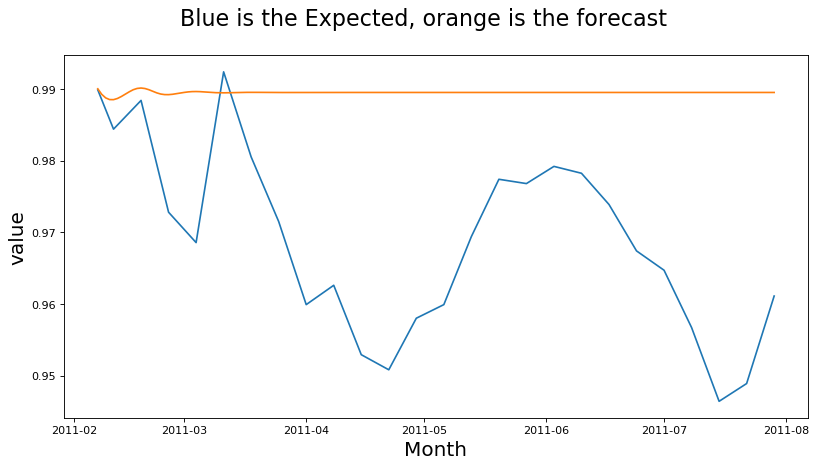

In [11]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 100,'relu',100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 [==============================] - 4s 7ms/step - loss: 0.0157
Epoch 2/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0052
Epoch 3/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 4/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0015
Epoch 5/100
378/378 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 6/100
378/378 [===============

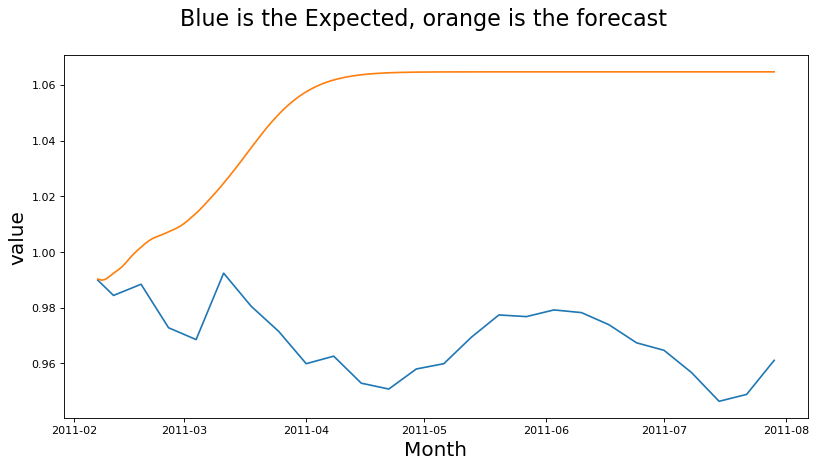

In [12]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 100,'tanh',100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 3ms/step - loss: 0.0242
Epoch 2/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 3/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 4/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 5/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 6/100
390/390 [===============

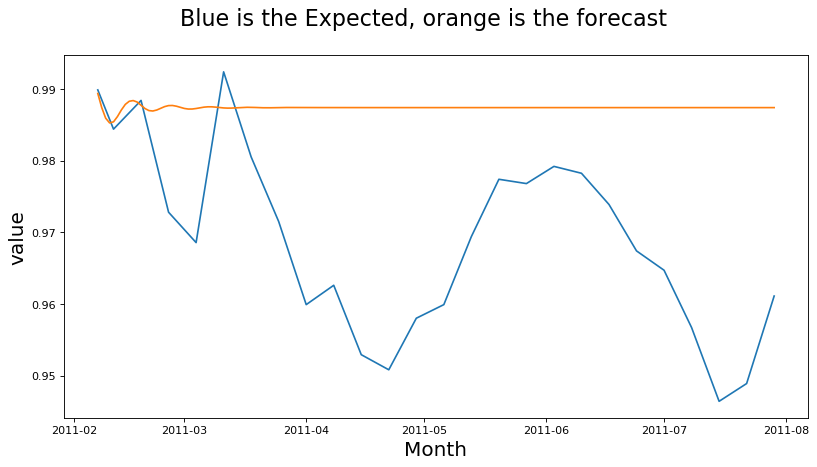

In [15]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'relu',50)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 3s 4ms/step - loss: 0.0176
Epoch 2/100
390/390 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 3/100
390/390 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 4/100
390/390 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 5/100
390/390 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 6/100
390/390 [===============

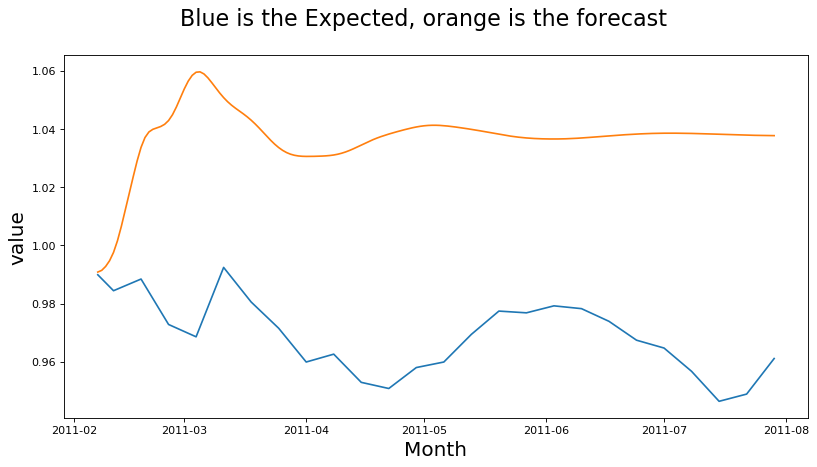

In [16]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'tanh',50)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 200)               161600    
                                                                 
 dense_8 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0162
Epoch 2/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0069
Epoch 3/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 4/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0027
Epoch 5/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 6/100
390/390 [=============

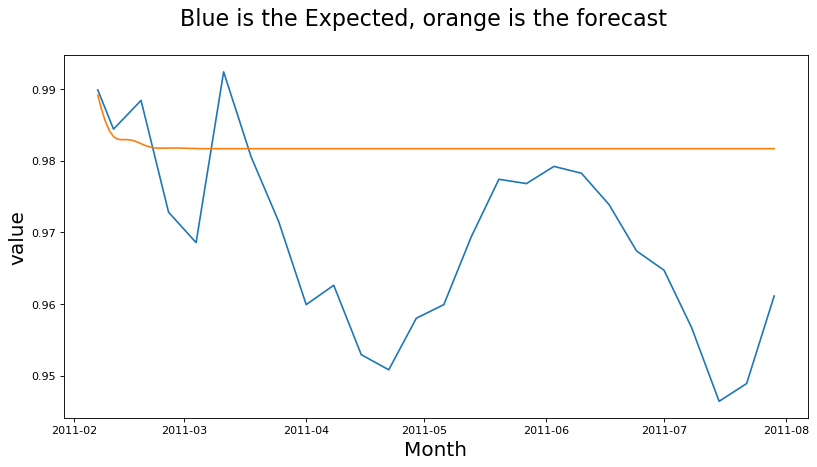

In [17]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'relu',200)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 200)               161600    
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 3s 5ms/step - loss: 0.0155
Epoch 2/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 3/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0022
Epoch 4/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 5/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 6/100
390/390 [=============

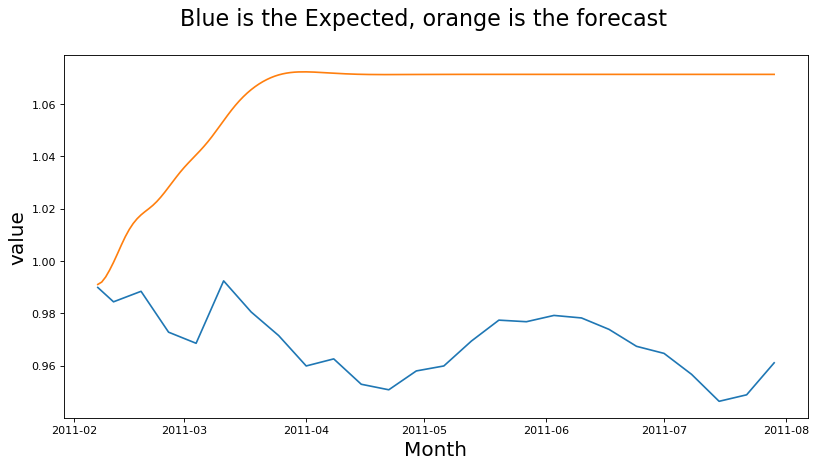

In [18]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'tanh',200)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 400)               643200    
                                                                 
 dense_12 (Dense)            (None, 1)                 401       
                                                                 
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0150
Epoch 2/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0057
Epoch 3/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0033
Epoch 4/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0016
Epoch 5/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0012
Epoch 6/100
390/390 [=======

390/390 [==============================] - 5s 12ms/step - loss: 2.7620e-04
Epoch 86/100
390/390 [==============================] - 5s 12ms/step - loss: 2.5898e-04
Epoch 87/100
390/390 [==============================] - 5s 12ms/step - loss: 2.5016e-04
Epoch 88/100
390/390 [==============================] - 5s 12ms/step - loss: 2.6774e-04
Epoch 89/100
390/390 [==============================] - 4s 12ms/step - loss: 2.4584e-04
Epoch 90/100
390/390 [==============================] - 5s 12ms/step - loss: 2.2771e-04
Epoch 91/100
390/390 [==============================] - 5s 12ms/step - loss: 2.5177e-04
Epoch 92/100
390/390 [==============================] - 5s 12ms/step - loss: 2.3556e-04
Epoch 93/100
390/390 [==============================] - 5s 12ms/step - loss: 2.3620e-04
Epoch 94/100
390/390 [==============================] - 5s 12ms/step - loss: 2.9519e-04
Epoch 95/100
390/390 [==============================] - 5s 12ms/step - loss: 2.1033e-04
Epoch 96/100
390/390 [=======================

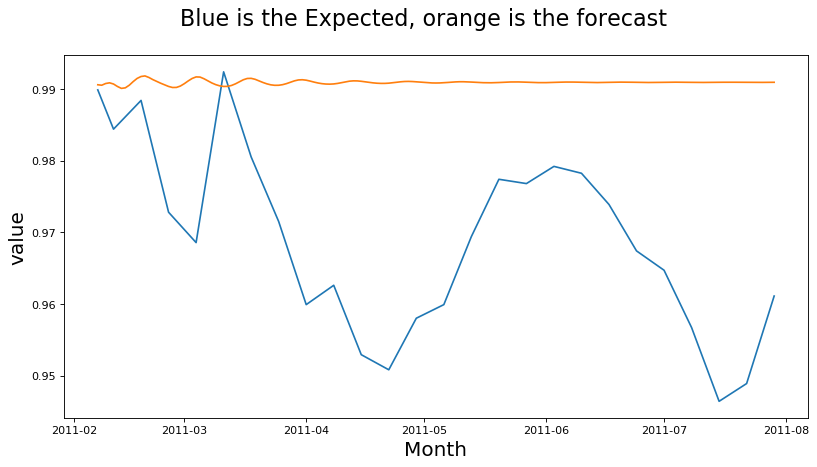

In [21]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 100,'relu',400)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 200)               161600    
                                                                 
 dense_14 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0198
Epoch 2/100
378/378 [==============================] - 2s 6ms/step - loss: 0.0075
Epoch 3/100
378/378 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 4/100
378/378 [==============================] - 2s 6ms/step - loss: 0.0025
Epoch 5/100
378/378 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 6/100
378/378 [============

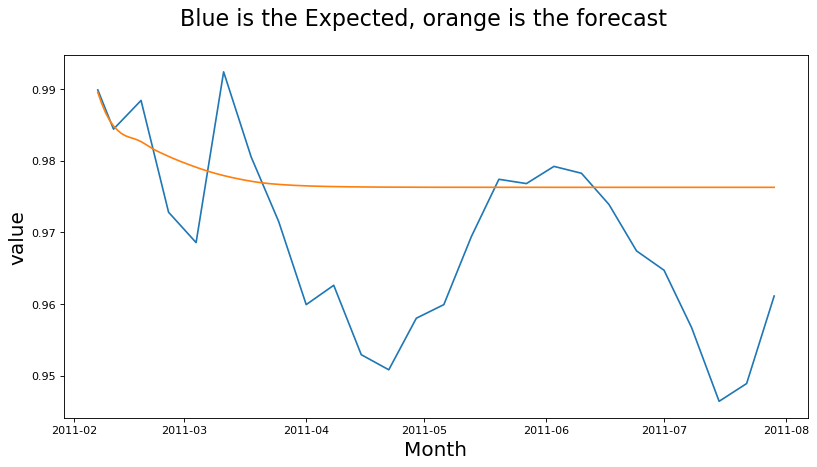

In [23]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 100,'relu',200)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 200)               161600    
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 [==============================] - 4s 7ms/step - loss: 0.0111
Epoch 2/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0029
Epoch 3/100
378/378 [==============================] - 3s 8ms/step - loss: 0.0016
Epoch 4/100
378/378 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 5/100
378/378 [==============================] - 3s 7ms/step - loss: 8.4677e-04
Epoch 6/100
378/378 [========

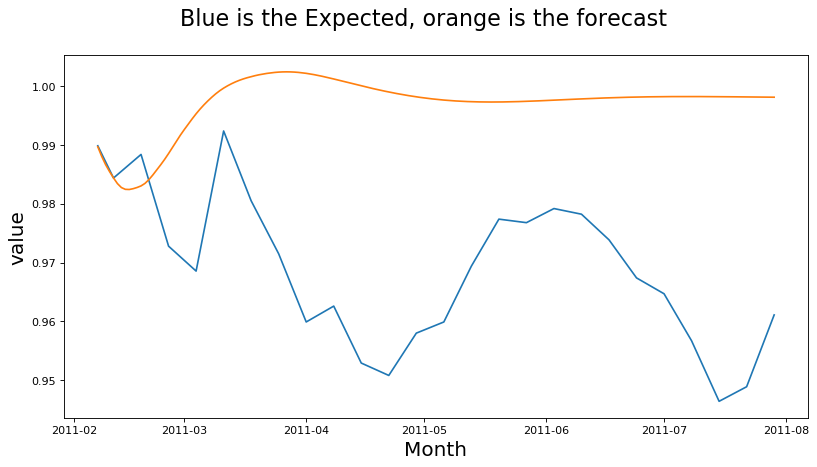

In [24]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 100,'tanh',200)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 200)               161600    
                                                                 
 dense_21 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
342/342 [==============================] - 6s 15ms/step - loss: 0.0116
Epoch 2/100
342/342 [==============================] - 5s 15ms/step - loss: 0.0032
Epoch 3/100
342/342 [==============================] - 5s 15ms/step - loss: 0.0015
Epoch 4/100
342/342 [==============================] - 5s 15ms/step - loss: 0.0013
Epoch 5/100
342/342 [==============================] - 5s 15ms/step - loss: 8.9947e-04
Epoch 6/100
342/342 [===

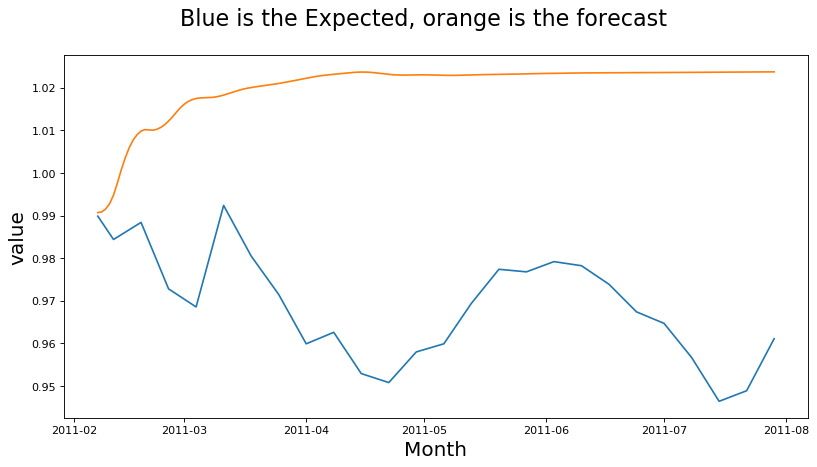

In [30]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 100,'tanh',200)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 200)               161600    
                                                                 
 dense_25 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
378/378 [==============================] - 4s 7ms/step - loss: 0.0093
Epoch 2/200
378/378 [==============================] - 3s 7ms/step - loss: 0.0026
Epoch 3/200
378/378 [==============================] - 3s 7ms/step - loss: 0.0015
Epoch 4/200
378/378 [==============================] - 3s 7ms/step - loss: 0.0012
Epoch 5/200
378/378 [==============================] - 3s 7ms/step - loss: 9.6491e-04
Epoch 6/200
378/378 [========

378/378 [==============================] - 3s 7ms/step - loss: 1.7138e-04
Epoch 181/200
378/378 [==============================] - 3s 7ms/step - loss: 1.7711e-04
Epoch 182/200
378/378 [==============================] - 3s 7ms/step - loss: 1.8553e-04
Epoch 183/200
378/378 [==============================] - 3s 7ms/step - loss: 1.8242e-04
Epoch 184/200
378/378 [==============================] - 3s 7ms/step - loss: 1.7760e-04
Epoch 185/200
378/378 [==============================] - 3s 7ms/step - loss: 1.6301e-04
Epoch 186/200
378/378 [==============================] - 3s 7ms/step - loss: 1.5988e-04
Epoch 187/200
378/378 [==============================] - 3s 7ms/step - loss: 1.8280e-04
Epoch 188/200
378/378 [==============================] - 3s 7ms/step - loss: 1.6869e-04
Epoch 189/200
378/378 [==============================] - 3s 7ms/step - loss: 1.7667e-04
Epoch 190/200
378/378 [==============================] - 3s 7ms/step - loss: 1.7140e-04
Epoch 191/200
378/378 [=======================

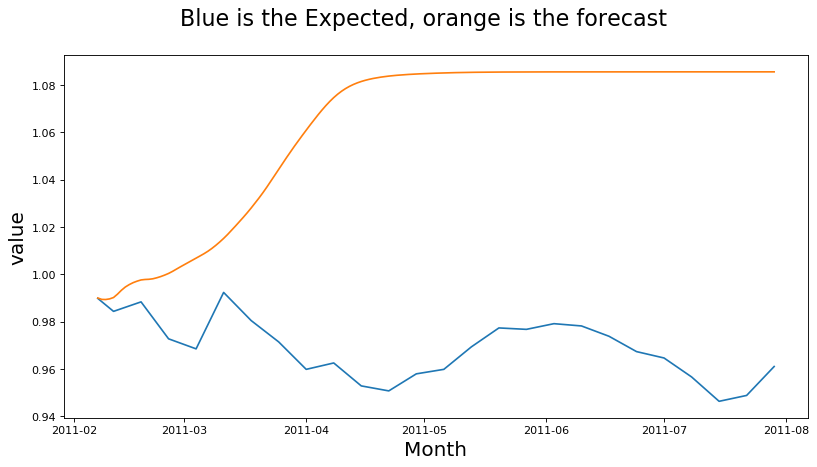

In [34]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 200,'tanh',200)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 200)               161600    
                                                                 
 dense_26 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
366/366 [==============================] - 4s 9ms/step - loss: 0.0137
Epoch 2/200
366/366 [==============================] - 3s 9ms/step - loss: 0.0060
Epoch 3/200
366/366 [==============================] - 3s 9ms/step - loss: 0.0026
Epoch 4/200
366/366 [==============================] - 3s 9ms/step - loss: 0.0017
Epoch 5/200
366/366 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 6/200
366/366 [============

366/366 [==============================] - 3s 9ms/step - loss: 1.7575e-04
Epoch 181/200
366/366 [==============================] - 3s 9ms/step - loss: 1.9266e-04
Epoch 182/200
366/366 [==============================] - 3s 9ms/step - loss: 1.9677e-04
Epoch 183/200
366/366 [==============================] - 3s 9ms/step - loss: 1.8133e-04
Epoch 184/200
366/366 [==============================] - 3s 9ms/step - loss: 1.8596e-04
Epoch 185/200
366/366 [==============================] - 3s 9ms/step - loss: 1.7858e-04
Epoch 186/200
366/366 [==============================] - 3s 9ms/step - loss: 1.8716e-04
Epoch 187/200
366/366 [==============================] - 3s 9ms/step - loss: 1.9704e-04
Epoch 188/200
366/366 [==============================] - 3s 9ms/step - loss: 1.9493e-04
Epoch 189/200
366/366 [==============================] - 3s 9ms/step - loss: 1.9587e-04
Epoch 190/200
366/366 [==============================] - 3s 9ms/step - loss: 2.1858e-04
Epoch 191/200
366/366 [=======================

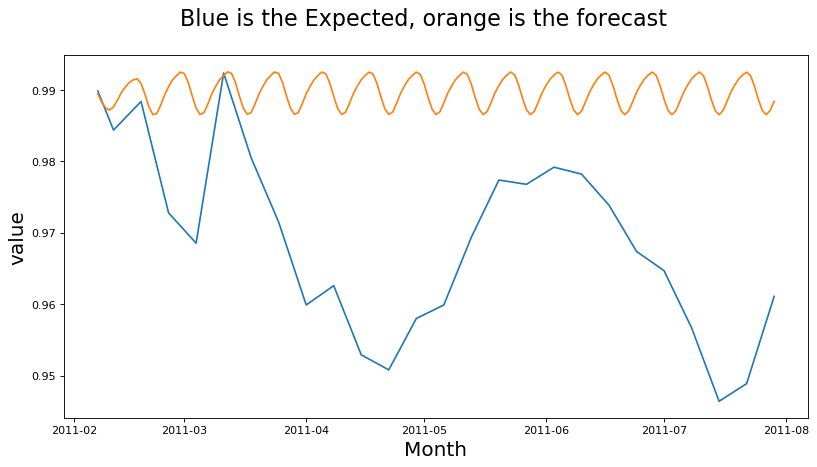

In [35]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 200,'relu',200)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 200)               161600    
                                                                 
 dense_27 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
366/366 [==============================] - 5s 10ms/step - loss: 0.0108
Epoch 2/200
366/366 [==============================] - 4s 10ms/step - loss: 0.0032
Epoch 3/200
366/366 [==============================] - 4s 10ms/step - loss: 0.0015
Epoch 4/200
366/366 [==============================] - 4s 10ms/step - loss: 0.0014
Epoch 5/200
366/366 [==============================] - 4s 10ms/step - loss: 0.0012
Epoch 6/200
366/366 [=======

366/366 [==============================] - 4s 10ms/step - loss: 1.8166e-04
Epoch 178/200
366/366 [==============================] - 4s 10ms/step - loss: 1.7026e-04
Epoch 179/200
366/366 [==============================] - 3s 10ms/step - loss: 1.7406e-04
Epoch 180/200
366/366 [==============================] - 4s 10ms/step - loss: 1.7401e-04
Epoch 181/200
366/366 [==============================] - 4s 10ms/step - loss: 1.5785e-04
Epoch 182/200
366/366 [==============================] - 4s 10ms/step - loss: 1.7406e-04
Epoch 183/200
366/366 [==============================] - 4s 10ms/step - loss: 1.7808e-04
Epoch 184/200
366/366 [==============================] - 4s 10ms/step - loss: 1.5550e-04
Epoch 185/200
366/366 [==============================] - 4s 10ms/step - loss: 1.5476e-04
Epoch 186/200
366/366 [==============================] - 4s 10ms/step - loss: 1.8398e-04
Epoch 187/200
366/366 [==============================] - 4s 10ms/step - loss: 1.9192e-04
Epoch 188/200
366/366 [============

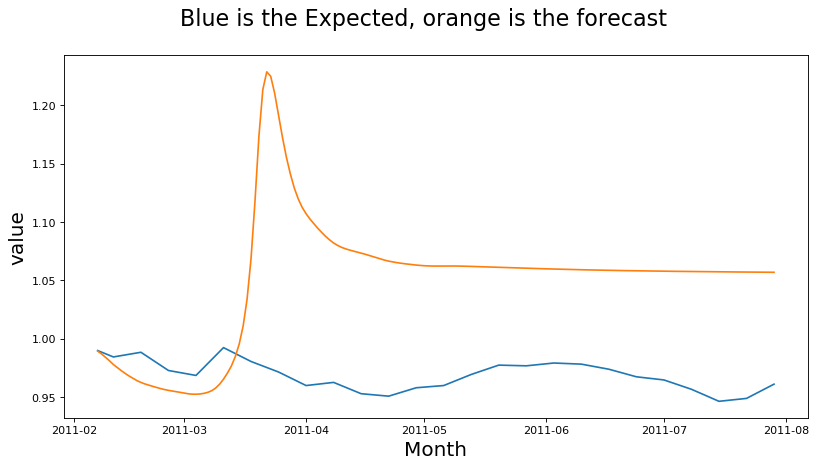

In [36]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 200,'tanh',200)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 200)               161600    
                                                                 
 dense_28 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
354/354 [==============================] - 5s 12ms/step - loss: 0.0186
Epoch 2/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0059
Epoch 3/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0034
Epoch 4/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0020
Epoch 5/200
354/354 [==============================] - 4s 12ms/step - loss: 9.9277e-04
Epoch 6/200
354/354 [===

354/354 [==============================] - 4s 12ms/step - loss: 3.2495e-04
Epoch 87/200
354/354 [==============================] - 4s 12ms/step - loss: 3.0000e-04
Epoch 88/200
354/354 [==============================] - 4s 11ms/step - loss: 2.7450e-04
Epoch 89/200
354/354 [==============================] - 4s 11ms/step - loss: 2.8132e-04
Epoch 90/200
354/354 [==============================] - 4s 11ms/step - loss: 2.7831e-04
Epoch 91/200
354/354 [==============================] - 4s 12ms/step - loss: 3.1128e-04
Epoch 92/200
354/354 [==============================] - 4s 11ms/step - loss: 2.5190e-04
Epoch 93/200
354/354 [==============================] - 4s 12ms/step - loss: 2.8083e-04
Epoch 94/200
354/354 [==============================] - 4s 12ms/step - loss: 2.9138e-04
Epoch 95/200
354/354 [==============================] - 4s 11ms/step - loss: 2.6442e-04: 1
Epoch 96/200
354/354 [==============================] - 4s 11ms/step - loss: 2.6036e-04
Epoch 97/200
354/354 [====================

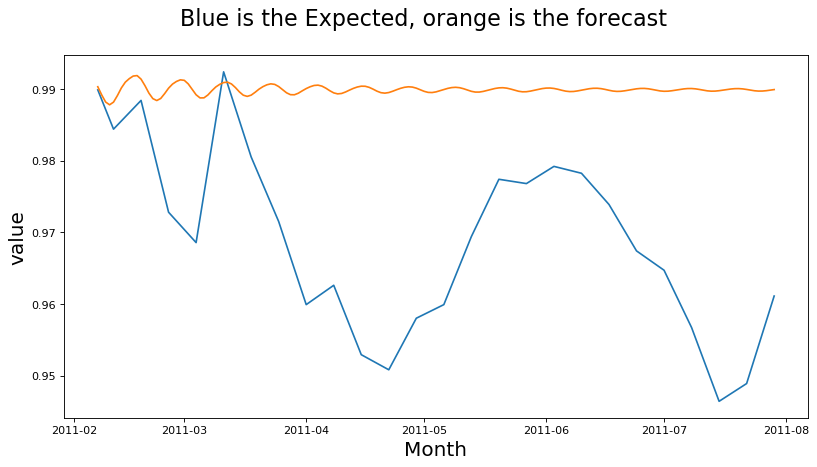

In [37]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 48, 1, 200,'relu',200)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 200)               161600    
                                                                 
 dense_29 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
354/354 [==============================] - 6s 12ms/step - loss: 0.0105
Epoch 2/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0034
Epoch 3/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0017
Epoch 4/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0014
Epoch 5/200
354/354 [==============================] - 4s 12ms/step - loss: 0.0010
Epoch 6/200
354/354 [=======

354/354 [==============================] - 4s 12ms/step - loss: 1.5059e-04
Epoch 177/200
354/354 [==============================] - 4s 12ms/step - loss: 1.8831e-04
Epoch 178/200
354/354 [==============================] - 4s 12ms/step - loss: 1.7223e-04
Epoch 179/200
354/354 [==============================] - 4s 12ms/step - loss: 1.6455e-04:
Epoch 180/200
354/354 [==============================] - 4s 12ms/step - loss: 1.9291e-04: 0s - loss: 1.9537
Epoch 181/200
354/354 [==============================] - 4s 12ms/step - loss: 1.5801e-04
Epoch 182/200
354/354 [==============================] - 4s 12ms/step - loss: 1.6106e-04
Epoch 183/200
354/354 [==============================] - 4s 12ms/step - loss: 1.6035e-04: 0s - los
Epoch 184/200
354/354 [==============================] - 4s 12ms/step - loss: 1.9331e-04: 0s - lo
Epoch 185/200
354/354 [==============================] - 4s 12ms/step - loss: 1.6819e-04
Epoch 186/200
354/354 [==============================] - 4s 12ms/step - loss: 1.8938e

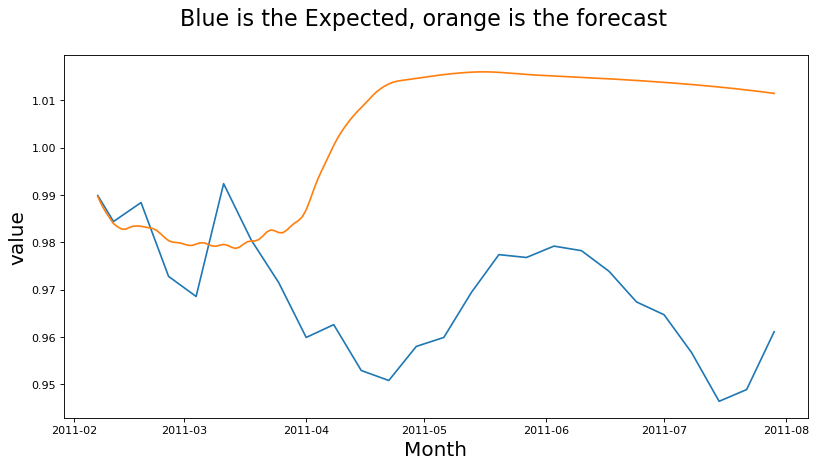

In [38]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 48, 1, 200,'tanh',200)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 200)               161600    
                                                                 
 dense_30 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
342/342 [==============================] - 6s 14ms/step - loss: 0.0146
Epoch 2/200
342/342 [==============================] - 5s 14ms/step - loss: 0.0063
Epoch 3/200
342/342 [==============================] - 5s 14ms/step - loss: 0.0039
Epoch 4/200
342/342 [==============================] - 5s 14ms/step - loss: 0.0022
Epoch 5/200
342/342 [==============================] - 5s 14ms/step - loss: 0.0015
Epoch 6/200
342/342 [=======

342/342 [==============================] - 5s 14ms/step - loss: 2.0785e-04
Epoch 179/200
342/342 [==============================] - 5s 14ms/step - loss: 1.8009e-04
Epoch 180/200
342/342 [==============================] - 5s 14ms/step - loss: 1.9423e-04
Epoch 181/200
342/342 [==============================] - 5s 14ms/step - loss: 1.9874e-04
Epoch 182/200
342/342 [==============================] - 5s 14ms/step - loss: 1.9305e-04
Epoch 183/200
342/342 [==============================] - 5s 14ms/step - loss: 2.0782e-04
Epoch 184/200
342/342 [==============================] - 5s 14ms/step - loss: 1.8092e-04
Epoch 185/200
342/342 [==============================] - 5s 14ms/step - loss: 2.1728e-04
Epoch 186/200
342/342 [==============================] - 5s 14ms/step - loss: 2.0021e-04
Epoch 187/200
342/342 [==============================] - 5s 14ms/step - loss: 1.7644e-04
Epoch 188/200
342/342 [==============================] - 5s 14ms/step - loss: 2.1333e-04
Epoch 189/200
342/342 [============

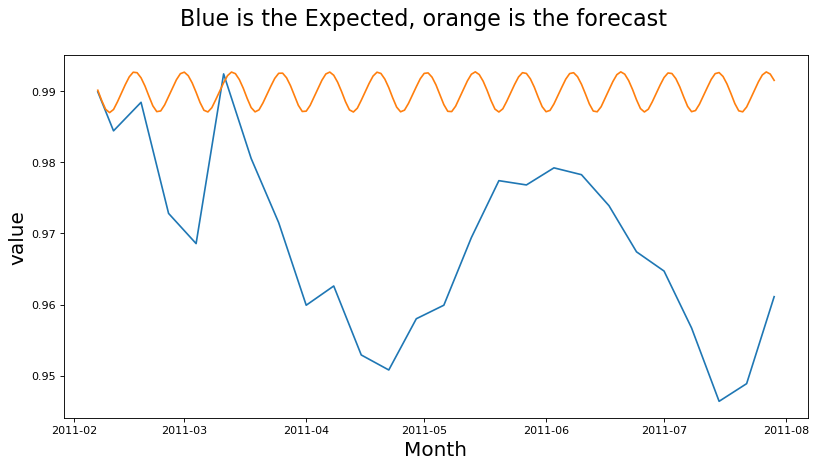

In [39]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 200,'relu',200)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 200)               161600    
                                                                 
 dense_31 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
342/342 [==============================] - 6s 15ms/step - loss: 0.0094
Epoch 2/200
342/342 [==============================] - 5s 15ms/step - loss: 0.0059: 0s - lo
Epoch 3/200
342/342 [==============================] - 5s 14ms/step - loss: 0.0030
Epoch 4/200
342/342 [==============================] - 5s 15ms/step - loss: 0.0019: 0s -
Epoch 5/200
342/342 [==============================] - 5s 15ms/step - loss: 0.0014
Epoch 6/200
3

342/342 [==============================] - 5s 15ms/step - loss: 1.7012e-04
Epoch 175/200
342/342 [==============================] - 5s 15ms/step - loss: 1.6688e-04: 1s 
Epoch 176/200
342/342 [==============================] - 5s 15ms/step - loss: 1.5861e-04
Epoch 177/200
342/342 [==============================] - 5s 15ms/step - loss: 2.6245e-04
Epoch 178/200
342/342 [==============================] - 5s 15ms/step - loss: 2.4640e-04
Epoch 179/200
342/342 [==============================] - 5s 15ms/step - loss: 2.1608e-04
Epoch 180/200
342/342 [==============================] - 5s 15ms/step - loss: 1.7279e-04
Epoch 181/200
342/342 [==============================] - 5s 15ms/step - loss: 2.0113e-04
Epoch 182/200
342/342 [==============================] - 5s 15ms/step - loss: 2.3471e-04
Epoch 183/200
342/342 [==============================] - 5s 15ms/step - loss: 2.2263e-04: 1s - loss: - ETA: 1s 
Epoch 184/200
342/342 [==============================] - 5s 15ms/step - loss: 2.1402e-04
Epoch 1

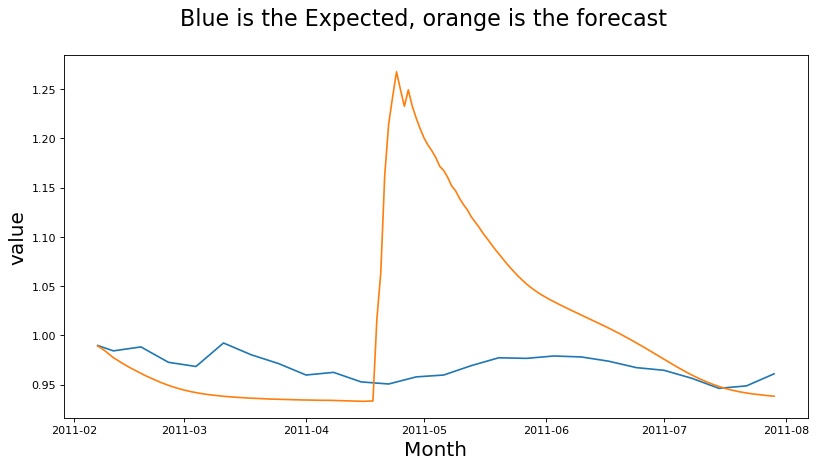

In [40]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 200,'tanh',200)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 200)               161600    
                                                                 
 dense_32 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0171
Epoch 2/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0061
Epoch 3/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0037
Epoch 4/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0024
Epoch 5/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 6/400
390/390 [============

390/390 [==============================] - 2s 4ms/step - loss: 2.1561e-04
Epoch 181/400
390/390 [==============================] - 2s 4ms/step - loss: 2.3153e-04
Epoch 182/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9483e-04
Epoch 183/400
390/390 [==============================] - 2s 4ms/step - loss: 2.2517e-04
Epoch 184/400
390/390 [==============================] - 2s 4ms/step - loss: 2.1324e-04
Epoch 185/400
390/390 [==============================] - 2s 4ms/step - loss: 1.8410e-04
Epoch 186/400
390/390 [==============================] - 2s 4ms/step - loss: 1.7972e-04
Epoch 187/400
390/390 [==============================] - 2s 4ms/step - loss: 1.8407e-04
Epoch 188/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9215e-04
Epoch 189/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9572e-04
Epoch 190/400
390/390 [==============================] - 2s 4ms/step - loss: 1.7124e-04
Epoch 191/400
390/390 [=======================

390/390 [==============================] - 2s 4ms/step - loss: 1.3158e-04
Epoch 366/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4092e-04
Epoch 367/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3248e-04
Epoch 368/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4883e-04
Epoch 369/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3670e-04
Epoch 370/400
390/390 [==============================] - 2s 4ms/step - loss: 1.1628e-04
Epoch 371/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3237e-04
Epoch 372/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3659e-04
Epoch 373/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4737e-04
Epoch 374/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4117e-04
Epoch 375/400
390/390 [==============================] - 2s 4ms/step - loss: 1.2550e-04
Epoch 376/400
390/390 [=======================

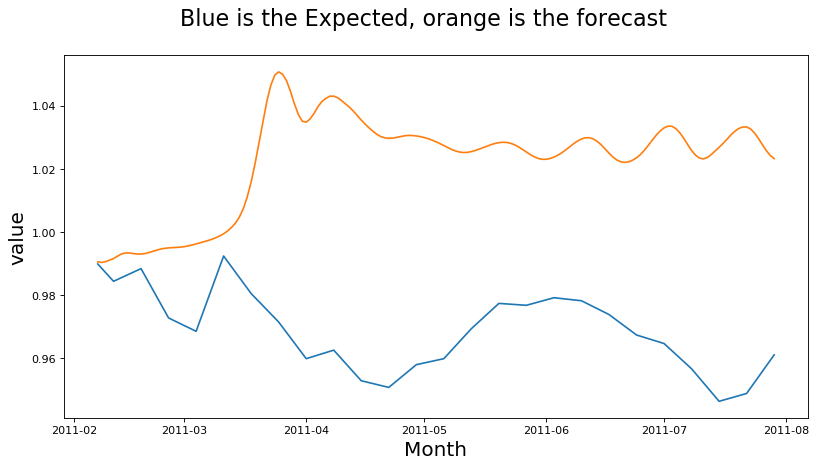

In [41]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 400,'relu',200)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 200)               161600    
                                                                 
 dense_33 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
390/390 [==============================] - 3s 5ms/step - loss: 0.0155
Epoch 2/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 3/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 4/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0018
Epoch 5/400
390/390 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 6/400
390/390 [============

390/390 [==============================] - 2s 4ms/step - loss: 1.8387e-04
Epoch 181/400
390/390 [==============================] - 2s 4ms/step - loss: 2.2396e-04
Epoch 182/400
390/390 [==============================] - 2s 4ms/step - loss: 1.8579e-04
Epoch 183/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9090e-04
Epoch 184/400
390/390 [==============================] - 2s 4ms/step - loss: 1.6988e-04
Epoch 185/400
390/390 [==============================] - 2s 5ms/step - loss: 2.0808e-04
Epoch 186/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9996e-04
Epoch 187/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9392e-04
Epoch 188/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9114e-04
Epoch 189/400
390/390 [==============================] - 2s 4ms/step - loss: 1.7925e-04
Epoch 190/400
390/390 [==============================] - 2s 4ms/step - loss: 1.9635e-04
Epoch 191/400
390/390 [=======================

390/390 [==============================] - 2s 4ms/step - loss: 1.2933e-04
Epoch 366/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3316e-04
Epoch 367/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3928e-04
Epoch 368/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4159e-04
Epoch 369/400
390/390 [==============================] - 2s 4ms/step - loss: 1.3121e-04
Epoch 370/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4434e-04
Epoch 371/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4222e-04
Epoch 372/400
390/390 [==============================] - 2s 4ms/step - loss: 1.2838e-04
Epoch 373/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4830e-04
Epoch 374/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4291e-04
Epoch 375/400
390/390 [==============================] - 2s 4ms/step - loss: 1.4199e-04
Epoch 376/400
390/390 [=======================

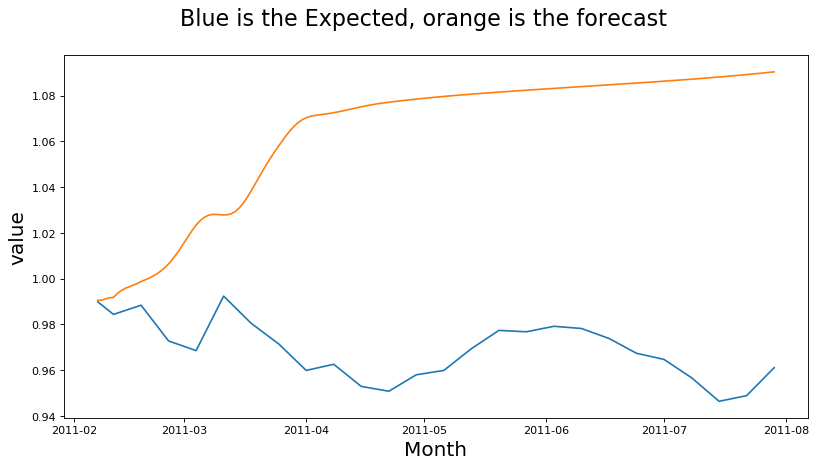

In [42]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 400,'tanh',200)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 200)               161600    
                                                                 
 dense_35 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
378/378 [==============================] - 4s 7ms/step - loss: 0.0127
Epoch 2/400
378/378 [==============================] - 3s 7ms/step - loss: 0.0039
Epoch 3/400
378/378 [==============================] - 3s 7ms/step - loss: 0.0019
Epoch 4/400
378/378 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 5/400
378/378 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 6/400
378/378 [============

378/378 [==============================] - 3s 7ms/step - loss: 2.3521e-04
Epoch 181/400
378/378 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 182/400
378/378 [==============================] - 3s 7ms/step - loss: 2.3640e-04
Epoch 183/400
378/378 [==============================] - 3s 7ms/step - loss: 2.0954e-04
Epoch 184/400
378/378 [==============================] - 3s 7ms/step - loss: 2.0501e-04
Epoch 185/400
378/378 [==============================] - 3s 7ms/step - loss: 2.0973e-04
Epoch 186/400
378/378 [==============================] - 3s 7ms/step - loss: 2.2618e-04
Epoch 187/400
378/378 [==============================] - 3s 7ms/step - loss: 2.1670e-04
Epoch 188/400
378/378 [==============================] - 3s 7ms/step - loss: 2.2742e-04
Epoch 189/400
378/378 [==============================] - 3s 7ms/step - loss: 2.3072e-04
Epoch 190/400
378/378 [==============================] - 3s 7ms/step - loss: 2.2506e-04
Epoch 191/400
378/378 [===========================

378/378 [==============================] - 3s 7ms/step - loss: 1.2442e-04
Epoch 367/400
378/378 [==============================] - 3s 7ms/step - loss: 1.2346e-04
Epoch 368/400
378/378 [==============================] - 3s 7ms/step - loss: 1.3277e-04
Epoch 369/400
378/378 [==============================] - 3s 7ms/step - loss: 1.2770e-04
Epoch 370/400
378/378 [==============================] - 3s 7ms/step - loss: 1.1449e-04
Epoch 371/400
378/378 [==============================] - 3s 7ms/step - loss: 1.1795e-04
Epoch 372/400
378/378 [==============================] - 3s 7ms/step - loss: 1.2622e-04
Epoch 373/400
378/378 [==============================] - 3s 7ms/step - loss: 1.3047e-04
Epoch 374/400
378/378 [==============================] - 3s 7ms/step - loss: 1.3145e-04
Epoch 375/400
378/378 [==============================] - 3s 7ms/step - loss: 1.0897e-04
Epoch 376/400
378/378 [==============================] - 3s 7ms/step - loss: 1.4099e-04
Epoch 377/400
378/378 [=======================

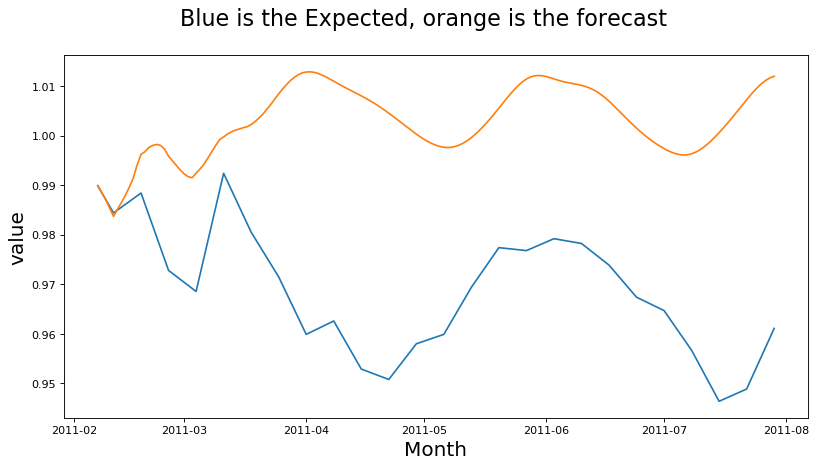

In [44]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 400,'tanh',200)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 200)               161600    
                                                                 
 dense_36 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
366/366 [==============================] - 4s 9ms/step - loss: 0.0157
Epoch 2/400
366/366 [==============================] - 3s 9ms/step - loss: 0.0061
Epoch 3/400
366/366 [==============================] - 3s 9ms/step - loss: 0.0037
Epoch 4/400
366/366 [==============================] - 3s 9ms/step - loss: 0.0017
Epoch 5/400
366/366 [==============================] - 3s 9ms/step - loss: 0.0013
Epoch 6/400
366/366 [============

366/366 [==============================] - 3s 9ms/step - loss: 1.8184e-04
Epoch 181/400
366/366 [==============================] - 3s 9ms/step - loss: 2.0786e-04
Epoch 182/400
366/366 [==============================] - 3s 9ms/step - loss: 1.9519e-04
Epoch 183/400
366/366 [==============================] - 3s 9ms/step - loss: 2.1137e-04
Epoch 184/400
366/366 [==============================] - 3s 9ms/step - loss: 1.8080e-04
Epoch 185/400
366/366 [==============================] - 3s 9ms/step - loss: 2.0117e-04
Epoch 186/400
366/366 [==============================] - 3s 9ms/step - loss: 1.9349e-04
Epoch 187/400
366/366 [==============================] - 3s 9ms/step - loss: 2.0833e-04
Epoch 188/400
366/366 [==============================] - 3s 9ms/step - loss: 1.9845e-04
Epoch 189/400
366/366 [==============================] - 3s 9ms/step - loss: 1.8383e-04
Epoch 190/400
366/366 [==============================] - 3s 9ms/step - loss: 1.7608e-04
Epoch 191/400
366/366 [=======================

366/366 [==============================] - 3s 9ms/step - loss: 1.1731e-04
Epoch 367/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0209e-04
Epoch 368/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0555e-04
Epoch 369/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0791e-04
Epoch 370/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0785e-04
Epoch 371/400
366/366 [==============================] - 3s 9ms/step - loss: 1.1300e-04
Epoch 372/400
366/366 [==============================] - 3s 9ms/step - loss: 1.1384e-04
Epoch 373/400
366/366 [==============================] - 3s 9ms/step - loss: 1.2452e-04
Epoch 374/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0047e-04
Epoch 375/400
366/366 [==============================] - 3s 9ms/step - loss: 1.1410e-04
Epoch 376/400
366/366 [==============================] - 3s 9ms/step - loss: 1.0622e-04
Epoch 377/400
366/366 [=======================

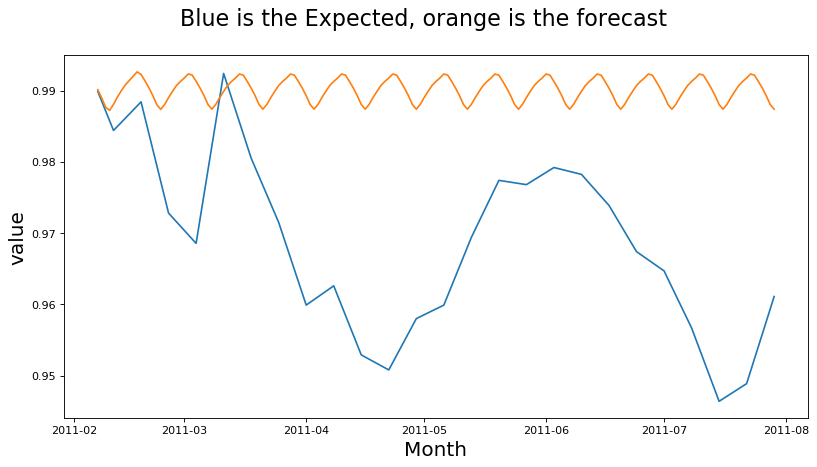

In [45]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 400,'relu',200)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 200)               161600    
                                                                 
 dense_37 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
366/366 [==============================] - 5s 10ms/step - loss: 0.0104
Epoch 2/400
366/366 [==============================] - 4s 10ms/step - loss: 0.0028: 0s - loss
Epoch 3/400
366/366 [==============================] - 4s 10ms/step - loss: 0.0017
Epoch 4/400
366/366 [==============================] - 4s 10ms/step - loss: 9.3723e-04
Epoch 5/400
366/366 [==============================] - 4s 10ms/step - loss: 9.8143e-04
Epoch 6/4

366/366 [==============================] - 4s 10ms/step - loss: 1.6430e-04
Epoch 177/400
366/366 [==============================] - 4s 10ms/step - loss: 1.5558e-04
Epoch 178/400
366/366 [==============================] - 4s 10ms/step - loss: 1.6563e-04
Epoch 179/400
366/366 [==============================] - 4s 10ms/step - loss: 1.6381e-04
Epoch 180/400
366/366 [==============================] - 4s 10ms/step - loss: 1.9837e-04
Epoch 181/400
366/366 [==============================] - 4s 10ms/step - loss: 1.4912e-04
Epoch 182/400
366/366 [==============================] - 4s 10ms/step - loss: 1.6759e-04
Epoch 183/400
366/366 [==============================] - 4s 10ms/step - loss: 1.5892e-04
Epoch 184/400
366/366 [==============================] - 4s 10ms/step - loss: 1.7862e-04
Epoch 185/400
366/366 [==============================] - 4s 10ms/step - loss: 1.9115e-04
Epoch 186/400
366/366 [==============================] - 4s 10ms/step - loss: 1.8432e-04
Epoch 187/400
366/366 [============

366/366 [==============================] - 4s 10ms/step - loss: 1.2539e-04
Epoch 359/400
366/366 [==============================] - 4s 10ms/step - loss: 1.1586e-04
Epoch 360/400
366/366 [==============================] - 4s 10ms/step - loss: 1.5892e-04
Epoch 361/400
366/366 [==============================] - 4s 10ms/step - loss: 1.2606e-04
Epoch 362/400
366/366 [==============================] - 4s 10ms/step - loss: 1.1100e-04
Epoch 363/400
366/366 [==============================] - 4s 10ms/step - loss: 1.1574e-04
Epoch 364/400
366/366 [==============================] - 4s 10ms/step - loss: 1.2858e-04
Epoch 365/400
366/366 [==============================] - 4s 10ms/step - loss: 1.3437e-04: 0s - loss: 1.1
Epoch 366/400
366/366 [==============================] - 4s 10ms/step - loss: 1.0859e-04
Epoch 367/400
366/366 [==============================] - 4s 10ms/step - loss: 1.2140e-04
Epoch 368/400
366/366 [==============================] - 4s 10ms/step - loss: 1.2116e-04
Epoch 369/400
366/3

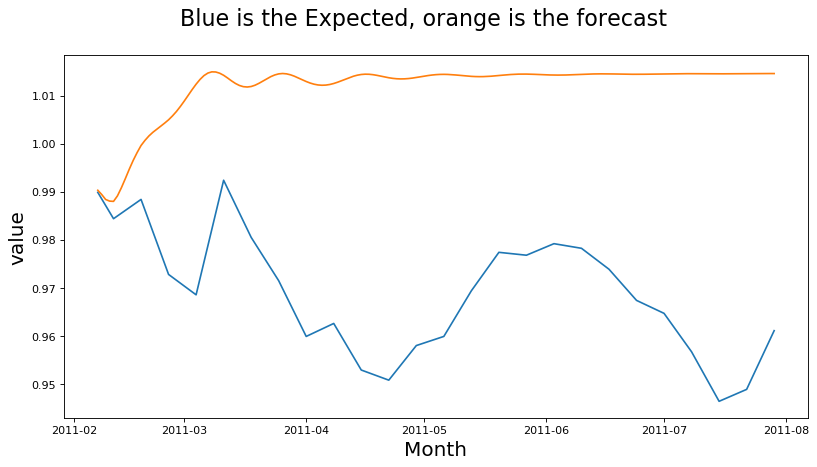

In [46]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 400,'tanh',200)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 200)               161600    
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
354/354 [==============================] - 6s 12ms/step - loss: 0.0151
Epoch 2/400
354/354 [==============================] - 4s 12ms/step - loss: 0.0036
Epoch 3/400
354/354 [==============================] - 4s 12ms/step - loss: 0.0017
Epoch 4/400
354/354 [==============================] - 4s 12ms/step - loss: 0.0012
Epoch 5/400
354/354 [==============================] - 4s 12ms/step - loss: 0.0013
Epoch 6/400
354/354 [=======

354/354 [==============================] - 4s 12ms/step - loss: 2.5620e-04
Epoch 177/400
354/354 [==============================] - 4s 12ms/step - loss: 2.4009e-04
Epoch 178/400
354/354 [==============================] - 4s 12ms/step - loss: 2.5712e-04
Epoch 179/400
354/354 [==============================] - 4s 12ms/step - loss: 2.5389e-04
Epoch 180/400
354/354 [==============================] - 4s 12ms/step - loss: 2.1326e-04
Epoch 181/400
354/354 [==============================] - 4s 12ms/step - loss: 2.0695e-04: 0s - loss: 
Epoch 182/400
354/354 [==============================] - 4s 12ms/step - loss: 4.1422e-04: 1s -
Epoch 183/400
354/354 [==============================] - 4s 12ms/step - loss: 2.1754e-04: 0s - los
Epoch 184/400
354/354 [==============================] - 4s 12ms/step - loss: 2.1498e-04
Epoch 185/400
354/354 [==============================] - 4s 12ms/step - loss: 2.0600e-04
Epoch 186/400
354/354 [==============================] - 4s 12ms/step - loss: 1.9877e-04
Epoch 

354/354 [==============================] - 4s 12ms/step - loss: 1.3630e-04
Epoch 268/400
354/354 [==============================] - 4s 12ms/step - loss: 1.4336e-04
Epoch 269/400
354/354 [==============================] - 4s 12ms/step - loss: 1.3473e-04
Epoch 270/400
354/354 [==============================] - 4s 12ms/step - loss: 1.4673e-04
Epoch 271/400
354/354 [==============================] - 4s 12ms/step - loss: 1.2422e-04
Epoch 272/400
354/354 [==============================] - 4s 12ms/step - loss: 1.3997e-04: 0s - lo
Epoch 273/400
354/354 [==============================] - 4s 12ms/step - loss: 1.5291e-04
Epoch 274/400
354/354 [==============================] - 4s 12ms/step - loss: 1.3414e-04
Epoch 275/400
354/354 [==============================] - 4s 12ms/step - loss: 1.5017e-04
Epoch 276/400
354/354 [==============================] - 4s 12ms/step - loss: 1.2861e-04
Epoch 277/400
354/354 [==============================] - 4s 12ms/step - loss: 1.5282e-04
Epoch 278/400
354/354 [===

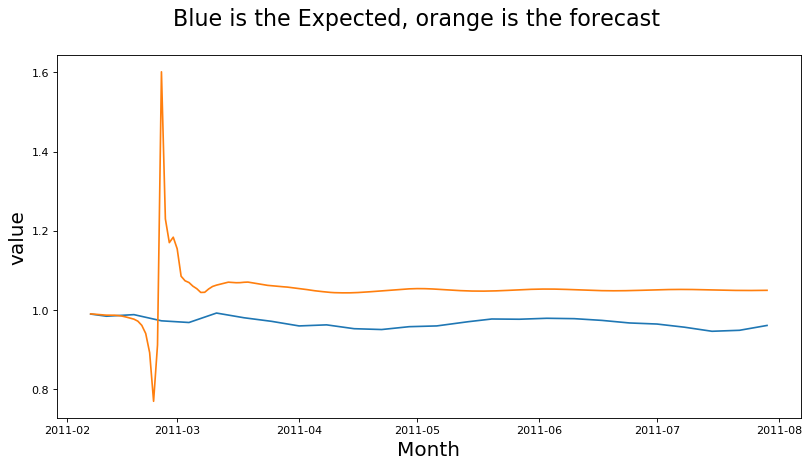

In [48]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 48, 1, 400,'tanh',200)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 200)               161600    
                                                                 
 dense_40 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
342/342 [==============================] - 6s 14ms/step - loss: 0.0164
Epoch 2/400
342/342 [==============================] - 5s 14ms/step - loss: 0.0064
Epoch 3/400
342/342 [==============================] - 5s 14ms/step - loss: 0.0037
Epoch 4/400
342/342 [==============================] - 5s 14ms/step - loss: 0.0019
Epoch 5/400
342/342 [==============================] - 5s 14ms/step - loss: 0.0012
Epoch 6/400
342/342 [=======

342/342 [==============================] - 5s 14ms/step - loss: 1.7935e-04
Epoch 179/400
342/342 [==============================] - 5s 14ms/step - loss: 1.6764e-04
Epoch 180/400
342/342 [==============================] - 5s 14ms/step - loss: 1.9412e-04
Epoch 181/400
342/342 [==============================] - 5s 14ms/step - loss: 1.7596e-04
Epoch 182/400
342/342 [==============================] - 5s 14ms/step - loss: 1.6816e-04
Epoch 183/400
342/342 [==============================] - 5s 14ms/step - loss: 1.7147e-04
Epoch 184/400
342/342 [==============================] - 5s 14ms/step - loss: 1.8042e-04
Epoch 185/400
342/342 [==============================] - 5s 14ms/step - loss: 1.8925e-04
Epoch 186/400
342/342 [==============================] - 5s 14ms/step - loss: 1.5946e-04
Epoch 187/400
342/342 [==============================] - 5s 14ms/step - loss: 1.7177e-04
Epoch 188/400
342/342 [==============================] - 5s 14ms/step - loss: 1.7853e-04
Epoch 189/400
342/342 [============

Epoch 270/400
342/342 [==============================] - 5s 14ms/step - loss: 1.1871e-04
Epoch 271/400
342/342 [==============================] - 5s 14ms/step - loss: 1.1998e-04
Epoch 272/400
342/342 [==============================] - 5s 14ms/step - loss: 1.0791e-04
Epoch 273/400
342/342 [==============================] - 5s 14ms/step - loss: 1.2150e-04
Epoch 274/400
342/342 [==============================] - 5s 14ms/step - loss: 1.3094e-04
Epoch 275/400
342/342 [==============================] - 5s 14ms/step - loss: 1.5051e-04
Epoch 276/400
342/342 [==============================] - 5s 14ms/step - loss: 1.2640e-04
Epoch 277/400
342/342 [==============================] - 5s 14ms/step - loss: 1.1614e-04
Epoch 278/400
342/342 [==============================] - 5s 14ms/step - loss: 1.5431e-04
Epoch 279/400
342/342 [==============================] - 5s 14ms/step - loss: 1.1771e-04
Epoch 280/400
342/342 [==============================] - 5s 14ms/step - loss: 1.2828e-04
Epoch 281/400
342/342

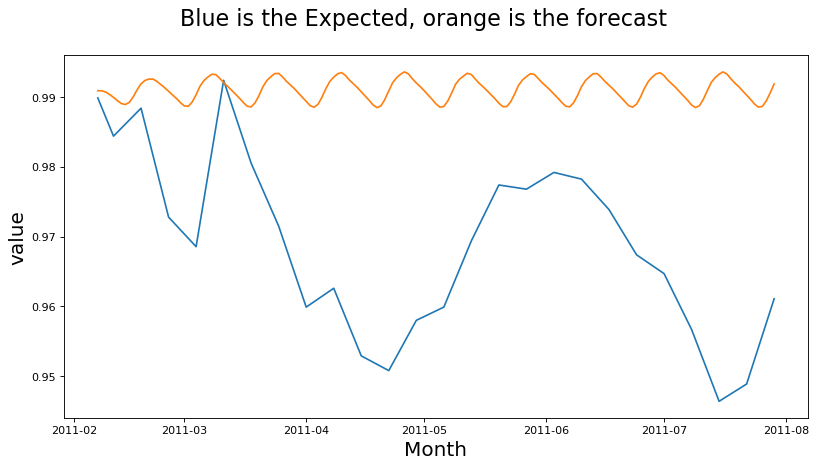

In [49]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 400,'relu',200)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 200)               161600    
                                                                 
 dense_41 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
342/342 [==============================] - 6s 15ms/step - loss: 0.0094
Epoch 2/400
342/342 [==============================] - 5s 15ms/step - loss: 0.0025
Epoch 3/400
342/342 [==============================] - 5s 15ms/step - loss: 0.0015
Epoch 4/400
342/342 [==============================] - 5s 15ms/step - loss: 9.5399e-04
Epoch 5/400
342/342 [==============================] - 5s 15ms/step - loss: 8.2182e-04
Epoch 6/400
342/342 

342/342 [==============================] - 5s 15ms/step - loss: 1.7966e-04: 0s - loss: 1
Epoch 176/400
342/342 [==============================] - 5s 15ms/step - loss: 1.8362e-04
Epoch 177/400
342/342 [==============================] - 5s 14ms/step - loss: 1.7626e-04
Epoch 178/400
342/342 [==============================] - 5s 15ms/step - loss: 1.5700e-04
Epoch 179/400
342/342 [==============================] - 5s 15ms/step - loss: 1.6901e-04
Epoch 180/400
342/342 [==============================] - 5s 15ms/step - loss: 1.5495e-04
Epoch 181/400
342/342 [==============================] - 5s 15ms/step - loss: 1.6319e-04
Epoch 182/400
342/342 [==============================] - 5s 15ms/step - loss: 1.8017e-04
Epoch 183/400
342/342 [==============================] - 5s 15ms/step - loss: 1.4293e-04: 1s
Epoch 184/400
342/342 [==============================] - 5s 15ms/step - loss: 1.3840e-04
Epoch 185/400
342/342 [==============================] - 5s 14ms/step - loss: 1.4742e-04
Epoch 186/400
342

342/342 [==============================] - 5s 15ms/step - loss: 1.2399e-04
Epoch 356/400
342/342 [==============================] - 5s 15ms/step - loss: 1.2326e-04
Epoch 357/400
342/342 [==============================] - 5s 15ms/step - loss: 1.0723e-04
Epoch 358/400
342/342 [==============================] - 5s 15ms/step - loss: 1.1561e-04
Epoch 359/400
342/342 [==============================] - 5s 15ms/step - loss: 1.0594e-04
Epoch 360/400
342/342 [==============================] - 5s 15ms/step - loss: 1.0477e-04
Epoch 361/400
342/342 [==============================] - 5s 15ms/step - loss: 1.0607e-04
Epoch 362/400
342/342 [==============================] - 5s 15ms/step - loss: 1.1467e-04
Epoch 363/400
342/342 [==============================] - 5s 15ms/step - loss: 1.1106e-04
Epoch 364/400
342/342 [==============================] - 5s 15ms/step - loss: 1.1658e-04
Epoch 365/400
342/342 [==============================] - 5s 15ms/step - loss: 1.0513e-04
Epoch 366/400
342/342 [============

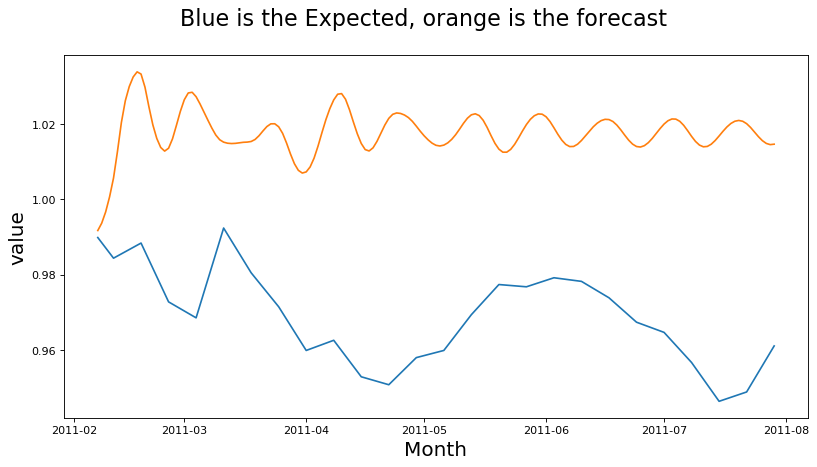

In [50]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 400,'tanh',200)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 200)               161600    
                                                                 
 dense_43 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
390/390 [==============================] - 3s 5ms/step - loss: 0.0092
Epoch 2/600
390/390 [==============================] - 2s 4ms/step - loss: 0.0029
Epoch 3/600
390/390 [==============================] - 2s 4ms/step - loss: 0.0018
Epoch 4/600
390/390 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 5/600
390/390 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 6/600
390/390 [============

Epoch 180/600
390/390 [==============================] - 2s 4ms/step - loss: 2.1281e-04
Epoch 181/600
390/390 [==============================] - 2s 4ms/step - loss: 2.0883e-04
Epoch 182/600
390/390 [==============================] - 2s 4ms/step - loss: 2.0195e-04
Epoch 183/600
390/390 [==============================] - 2s 4ms/step - loss: 2.0157e-04
Epoch 184/600
390/390 [==============================] - 2s 4ms/step - loss: 2.1667e-04
Epoch 185/600
390/390 [==============================] - 2s 4ms/step - loss: 2.0287e-04
Epoch 186/600
390/390 [==============================] - 2s 4ms/step - loss: 2.0055e-04
Epoch 187/600
390/390 [==============================] - 2s 4ms/step - loss: 2.1135e-04
Epoch 188/600
390/390 [==============================] - 2s 5ms/step - loss: 1.9647e-04
Epoch 189/600
390/390 [==============================] - 2s 4ms/step - loss: 1.8727e-04
Epoch 190/600
390/390 [==============================] - 2s 4ms/step - loss: 1.8575e-04
Epoch 191/600
390/390 [=========

390/390 [==============================] - 2s 4ms/step - loss: 1.6686e-04
Epoch 274/600
390/390 [==============================] - 2s 4ms/step - loss: 1.5414e-04
Epoch 275/600
390/390 [==============================] - 2s 4ms/step - loss: 1.5774e-04
Epoch 276/600
390/390 [==============================] - 2s 5ms/step - loss: 1.7698e-04
Epoch 277/600
390/390 [==============================] - 2s 5ms/step - loss: 1.6332e-04
Epoch 278/600
390/390 [==============================] - 2s 5ms/step - loss: 1.8251e-04
Epoch 279/600
390/390 [==============================] - 2s 4ms/step - loss: 1.4413e-04
Epoch 280/600
390/390 [==============================] - 2s 4ms/step - loss: 1.7423e-04
Epoch 281/600
390/390 [==============================] - 2s 4ms/step - loss: 1.6399e-04
Epoch 282/600
390/390 [==============================] - 2s 4ms/step - loss: 1.5022e-04
Epoch 283/600
390/390 [==============================] - 2s 5ms/step - loss: 1.6152e-04
Epoch 284/600
390/390 [=======================

390/390 [==============================] - 2s 4ms/step - loss: 1.4109e-04
Epoch 460/600
390/390 [==============================] - 2s 4ms/step - loss: 1.3731e-04
Epoch 461/600
390/390 [==============================] - 2s 5ms/step - loss: 1.4044e-04
Epoch 462/600
390/390 [==============================] - 2s 4ms/step - loss: 1.3113e-04
Epoch 463/600
390/390 [==============================] - 2s 4ms/step - loss: 1.4302e-04
Epoch 464/600
390/390 [==============================] - 2s 4ms/step - loss: 1.3158e-04
Epoch 465/600
390/390 [==============================] - 2s 4ms/step - loss: 1.2858e-04
Epoch 466/600
390/390 [==============================] - 2s 4ms/step - loss: 1.3220e-04
Epoch 467/600
390/390 [==============================] - 2s 4ms/step - loss: 1.1947e-04
Epoch 468/600
390/390 [==============================] - 2s 4ms/step - loss: 1.3378e-04
Epoch 469/600
390/390 [==============================] - 2s 4ms/step - loss: 1.4825e-04
Epoch 470/600
390/390 [=======================

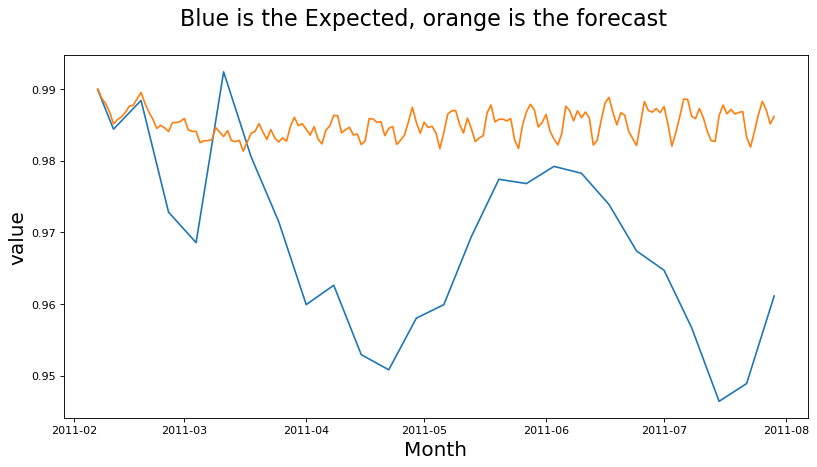

In [52]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 12, 1, 600,'tanh',200)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 200)               161600    
                                                                 
 dense_47 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
366/366 [==============================] - 5s 11ms/step - loss: 0.0105
Epoch 2/600
366/366 [==============================] - 4s 10ms/step - loss: 0.0029
Epoch 3/600
366/366 [==============================] - 4s 10ms/step - loss: 0.0016
Epoch 4/600
366/366 [==============================] - 4s 10ms/step - loss: 0.0012
Epoch 5/600
366/366 [==============================] - 4s 10ms/step - loss: 9.9616e-04
Epoch 6/600
366/366 [===

366/366 [==============================] - 4s 11ms/step - loss: 4.3323e-04
Epoch 179/600
366/366 [==============================] - 4s 11ms/step - loss: 2.5281e-04
Epoch 180/600
366/366 [==============================] - 4s 11ms/step - loss: 2.4207e-04
Epoch 181/600
366/366 [==============================] - 4s 11ms/step - loss: 2.2943e-04
Epoch 182/600
366/366 [==============================] - 4s 11ms/step - loss: 2.3333e-04
Epoch 183/600
366/366 [==============================] - 4s 11ms/step - loss: 2.2752e-04
Epoch 184/600
366/366 [==============================] - 4s 11ms/step - loss: 2.1825e-04
Epoch 185/600
366/366 [==============================] - 4s 11ms/step - loss: 2.0078e-04
Epoch 186/600
366/366 [==============================] - 4s 11ms/step - loss: 2.1543e-04
Epoch 187/600
366/366 [==============================] - 4s 11ms/step - loss: 1.9785e-04
Epoch 188/600
366/366 [==============================] - 4s 11ms/step - loss: 1.9333e-04
Epoch 189/600
366/366 [============

366/366 [==============================] - 4s 11ms/step - loss: 1.1708e-04
Epoch 363/600
366/366 [==============================] - 4s 11ms/step - loss: 1.2081e-04
Epoch 364/600
366/366 [==============================] - 4s 11ms/step - loss: 1.0907e-04
Epoch 365/600
366/366 [==============================] - 4s 11ms/step - loss: 1.1538e-04
Epoch 366/600
366/366 [==============================] - 4s 11ms/step - loss: 1.0773e-04
Epoch 367/600
366/366 [==============================] - 4s 11ms/step - loss: 1.1781e-04
Epoch 368/600
366/366 [==============================] - 4s 11ms/step - loss: 1.4765e-04
Epoch 369/600
366/366 [==============================] - 4s 11ms/step - loss: 9.9881e-05
Epoch 370/600
366/366 [==============================] - 4s 11ms/step - loss: 1.2639e-04
Epoch 371/600
366/366 [==============================] - 4s 10ms/step - loss: 1.1759e-04
Epoch 372/600
366/366 [==============================] - 4s 10ms/step - loss: 1.2609e-04
Epoch 373/600
366/366 [============

366/366 [==============================] - 4s 11ms/step - loss: 9.0024e-05
Epoch 546/600
366/366 [==============================] - 4s 11ms/step - loss: 7.7014e-05
Epoch 547/600
366/366 [==============================] - 4s 11ms/step - loss: 9.3620e-05
Epoch 548/600
366/366 [==============================] - 4s 11ms/step - loss: 7.5806e-05
Epoch 549/600
366/366 [==============================] - 4s 11ms/step - loss: 7.7301e-05
Epoch 550/600
366/366 [==============================] - 4s 11ms/step - loss: 7.0692e-05
Epoch 551/600
366/366 [==============================] - 4s 11ms/step - loss: 6.8878e-05
Epoch 552/600
366/366 [==============================] - 4s 11ms/step - loss: 8.2177e-05
Epoch 553/600
366/366 [==============================] - 4s 11ms/step - loss: 8.0704e-05
Epoch 554/600
366/366 [==============================] - 4s 11ms/step - loss: 8.9961e-05
Epoch 555/600
366/366 [==============================] - 4s 11ms/step - loss: 7.5744e-05
Epoch 556/600
366/366 [============

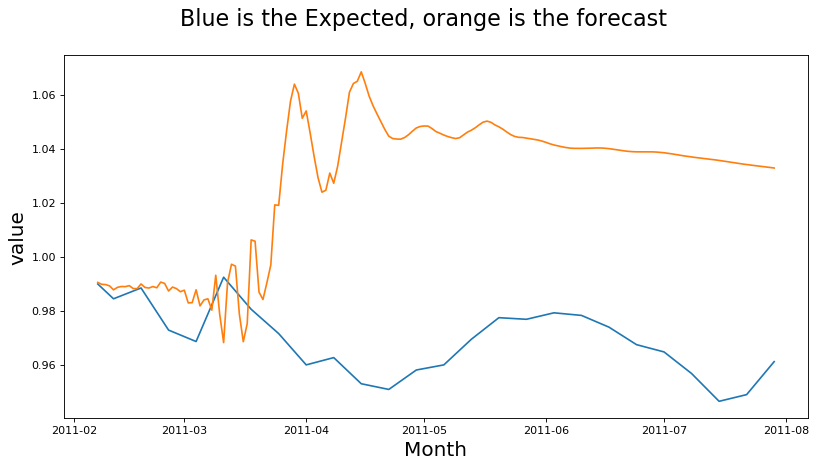

In [56]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 600,'tanh',200)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 200)               161600    
                                                                 
 dense_49 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
354/354 [==============================] - 6s 13ms/step - loss: 0.0120
Epoch 2/600
354/354 [==============================] - 5s 13ms/step - loss: 0.0034
Epoch 3/600
354/354 [==============================] - 5s 13ms/step - loss: 0.0021
Epoch 4/600
354/354 [==============================] - 5s 13ms/step - loss: 0.0011
Epoch 5/600
354/354 [==============================] - 5s 13ms/step - loss: 9.7655e-04
Epoch 6/600
354/354 [===

354/354 [==============================] - 5s 13ms/step - loss: 1.8445e-04
Epoch 179/600
354/354 [==============================] - 5s 13ms/step - loss: 2.0496e-04
Epoch 180/600
354/354 [==============================] - 5s 13ms/step - loss: 1.9663e-04
Epoch 181/600
354/354 [==============================] - 5s 13ms/step - loss: 1.9361e-04
Epoch 182/600
354/354 [==============================] - 5s 13ms/step - loss: 1.9243e-04
Epoch 183/600
354/354 [==============================] - 5s 13ms/step - loss: 2.0596e-04
Epoch 184/600
354/354 [==============================] - 5s 13ms/step - loss: 1.8674e-04
Epoch 185/600
354/354 [==============================] - 4s 13ms/step - loss: 2.0701e-04
Epoch 186/600
354/354 [==============================] - 4s 13ms/step - loss: 2.0278e-04
Epoch 187/600
354/354 [==============================] - 4s 13ms/step - loss: 1.8609e-04
Epoch 188/600
354/354 [==============================] - 4s 12ms/step - loss: 1.9542e-04
Epoch 189/600
354/354 [============

354/354 [==============================] - 4s 12ms/step - loss: 1.1526e-04
Epoch 361/600
354/354 [==============================] - 4s 13ms/step - loss: 1.1127e-04: 1s
Epoch 362/600
354/354 [==============================] - 4s 12ms/step - loss: 1.1377e-04
Epoch 363/600
354/354 [==============================] - 4s 12ms/step - loss: 1.2240e-04
Epoch 364/600
354/354 [==============================] - 4s 12ms/step - loss: 1.1622e-04
Epoch 365/600
354/354 [==============================] - 4s 12ms/step - loss: 1.1760e-04: 0s - lo
Epoch 366/600
354/354 [==============================] - 4s 12ms/step - loss: 1.2066e-04
Epoch 367/600
354/354 [==============================] - 4s 12ms/step - loss: 1.2222e-04
Epoch 368/600
354/354 [==============================] - 4s 12ms/step - loss: 1.2076e-04
Epoch 369/600
354/354 [==============================] - 4s 12ms/step - loss: 1.0977e-04
Epoch 370/600
354/354 [==============================] - 4s 12ms/step - loss: 1.1508e-04
Epoch 371/600
354/354 

354/354 [==============================] - 5s 13ms/step - loss: 8.9065e-05
Epoch 543/600
354/354 [==============================] - 5s 13ms/step - loss: 7.9632e-05
Epoch 544/600
354/354 [==============================] - 5s 13ms/step - loss: 9.4250e-05
Epoch 545/600
354/354 [==============================] - 5s 13ms/step - loss: 8.4039e-05
Epoch 546/600
354/354 [==============================] - 5s 13ms/step - loss: 1.0035e-04
Epoch 547/600
354/354 [==============================] - 5s 14ms/step - loss: 8.4030e-05
Epoch 548/600
354/354 [==============================] - 5s 13ms/step - loss: 8.2120e-05
Epoch 549/600
354/354 [==============================] - 4s 13ms/step - loss: 8.9637e-05
Epoch 550/600
354/354 [==============================] - 4s 13ms/step - loss: 9.1830e-05
Epoch 551/600
354/354 [==============================] - 5s 13ms/step - loss: 8.5722e-05
Epoch 552/600
354/354 [==============================] - 5s 13ms/step - loss: 9.4413e-05
Epoch 553/600
354/354 [============

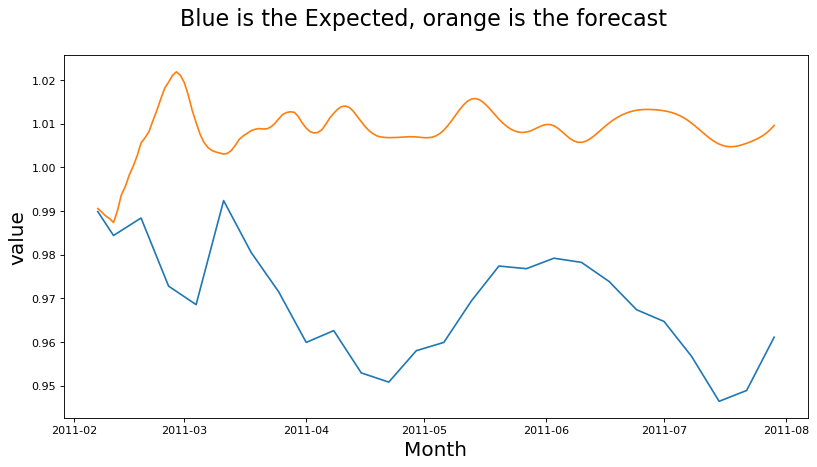

In [58]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 48, 1, 600,'tanh',200)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 200)               161600    
                                                                 
 dense_50 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
342/342 [==============================] - 6s 14ms/step - loss: 0.0149
Epoch 2/600
342/342 [==============================] - 5s 14ms/step - loss: 0.0055
Epoch 3/600
342/342 [==============================] - 5s 14ms/step - loss: 0.0033
Epoch 4/600
342/342 [==============================] - 5s 14ms/step - loss: 0.0018
Epoch 5/600
342/342 [==============================] - 5s 14ms/step - loss: 0.0012
Epoch 6/600
342/342 [=======

342/342 [==============================] - 5s 15ms/step - loss: 2.7812e-04
Epoch 87/600
342/342 [==============================] - 5s 15ms/step - loss: 2.9931e-04: 0s - loss: 3.0
Epoch 88/600
342/342 [==============================] - 5s 14ms/step - loss: 2.8205e-04
Epoch 89/600
342/342 [==============================] - 5s 14ms/step - loss: 2.7106e-04
Epoch 90/600
342/342 [==============================] - 5s 15ms/step - loss: 2.6168e-04
Epoch 91/600
342/342 [==============================] - 5s 14ms/step - loss: 2.7042e-04
Epoch 92/600
342/342 [==============================] - 5s 14ms/step - loss: 2.8874e-04
Epoch 93/600
342/342 [==============================] - 5s 14ms/step - loss: 2.7804e-04
Epoch 94/600
342/342 [==============================] - 5s 14ms/step - loss: 2.6336e-04
Epoch 95/600
342/342 [==============================] - 5s 14ms/step - loss: 2.5854e-04
Epoch 96/600
342/342 [==============================] - 5s 14ms/step - loss: 3.1215e-04
Epoch 97/600
342/342 [=======

342/342 [==============================] - 5s 14ms/step - loss: 2.1986e-04
Epoch 179/600
342/342 [==============================] - 5s 14ms/step - loss: 1.9361e-04
Epoch 180/600
342/342 [==============================] - 5s 14ms/step - loss: 1.8156e-04
Epoch 181/600
342/342 [==============================] - 5s 14ms/step - loss: 1.5845e-04: 2s - ETA: 1s
Epoch 182/600
342/342 [==============================] - 5s 14ms/step - loss: 1.9465e-04
Epoch 183/600
342/342 [==============================] - 5s 14ms/step - loss: 1.9693e-04
Epoch 184/600
342/342 [==============================] - 5s 14ms/step - loss: 2.1181e-04
Epoch 185/600
342/342 [==============================] - 5s 14ms/step - loss: 1.7073e-04
Epoch 186/600
342/342 [==============================] - 5s 15ms/step - loss: 1.6217e-04
Epoch 187/600
342/342 [==============================] - 5s 15ms/step - loss: 1.8085e-04
Epoch 188/600
342/342 [==============================] - 5s 15ms/step - loss: 1.8694e-04
Epoch 189/600
342/342

342/342 [==============================] - 5s 14ms/step - loss: 1.0325e-04
Epoch 361/600
342/342 [==============================] - 5s 14ms/step - loss: 1.1625e-04
Epoch 362/600
342/342 [==============================] - 5s 14ms/step - loss: 1.0225e-04
Epoch 363/600
342/342 [==============================] - 5s 14ms/step - loss: 9.5740e-05
Epoch 364/600
342/342 [==============================] - 5s 14ms/step - loss: 1.3099e-04
Epoch 365/600
342/342 [==============================] - 5s 14ms/step - loss: 1.1758e-04
Epoch 366/600
342/342 [==============================] - 5s 14ms/step - loss: 1.0413e-04
Epoch 367/600
342/342 [==============================] - 5s 14ms/step - loss: 9.9699e-05
Epoch 368/600
342/342 [==============================] - 5s 15ms/step - loss: 9.5317e-05
Epoch 369/600
342/342 [==============================] - 5s 14ms/step - loss: 9.7698e-05
Epoch 370/600
342/342 [==============================] - 5s 15ms/step - loss: 1.1513e-04
Epoch 371/600
342/342 [============

342/342 [==============================] - 5s 14ms/step - loss: 8.6824e-05
Epoch 543/600
342/342 [==============================] - 5s 14ms/step - loss: 9.5589e-05
Epoch 544/600
342/342 [==============================] - 5s 14ms/step - loss: 9.1086e-05
Epoch 545/600
342/342 [==============================] - 5s 14ms/step - loss: 8.3606e-05
Epoch 546/600
342/342 [==============================] - 5s 14ms/step - loss: 8.8427e-05
Epoch 547/600
342/342 [==============================] - 5s 14ms/step - loss: 9.8862e-05
Epoch 548/600
342/342 [==============================] - 5s 14ms/step - loss: 8.3647e-05
Epoch 549/600
342/342 [==============================] - 5s 14ms/step - loss: 9.1949e-05
Epoch 550/600
342/342 [==============================] - 5s 14ms/step - loss: 9.3665e-05
Epoch 551/600
342/342 [==============================] - 5s 14ms/step - loss: 7.9182e-05: 0s - loss: 6.6
Epoch 552/600
342/342 [==============================] - 5s 14ms/step - loss: 1.0502e-04
Epoch 553/600
342/3

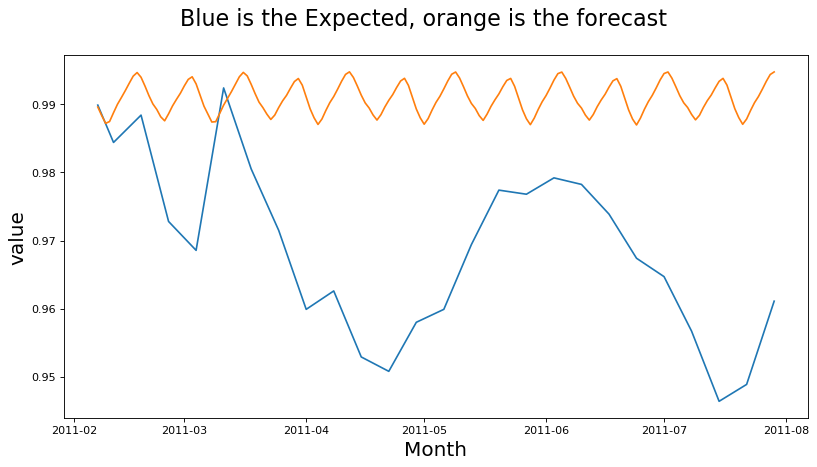

In [59]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 600,'relu',200)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 200)               161600    
                                                                 
 dense_51 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
342/342 [==============================] - 6s 15ms/step - loss: 0.0093
Epoch 2/600
342/342 [==============================] - 5s 15ms/step - loss: 0.0024
Epoch 3/600
342/342 [==============================] - 5s 15ms/step - loss: 0.0015: 0s - lo - ETA: 0s - loss:
Epoch 4/600
342/342 [==============================] - 5s 15ms/step - loss: 0.0013
Epoch 5/600
342/342 [==============================] - 5s 15ms/step - loss: 0.0012
E

Epoch 85/600
342/342 [==============================] - 5s 16ms/step - loss: 2.4400e-04
Epoch 86/600
342/342 [==============================] - 5s 16ms/step - loss: 2.6005e-04: 0s -
Epoch 87/600
342/342 [==============================] - 5s 16ms/step - loss: 2.7338e-04
Epoch 88/600
342/342 [==============================] - 5s 16ms/step - loss: 2.5130e-04
Epoch 89/600
342/342 [==============================] - 5s 16ms/step - loss: 2.5256e-04
Epoch 90/600
342/342 [==============================] - 5s 16ms/step - loss: 2.5038e-04
Epoch 91/600
342/342 [==============================] - 5s 15ms/step - loss: 2.4934e-04: 0s - l
Epoch 92/600
342/342 [==============================] - 5s 15ms/step - loss: 2.4949e-04
Epoch 93/600
342/342 [==============================] - 5s 15ms/step - loss: 3.1772e-04
Epoch 94/600
342/342 [==============================] - 5s 15ms/step - loss: 3.0735e-04
Epoch 95/600
342/342 [==============================] - 5s 15ms/step - loss: 2.9369e-04
Epoch 96/600
342/3

342/342 [==============================] - 5s 15ms/step - loss: 1.4487e-04
Epoch 266/600
342/342 [==============================] - 5s 16ms/step - loss: 1.3876e-04
Epoch 267/600
342/342 [==============================] - 6s 16ms/step - loss: 1.3524e-04
Epoch 268/600
342/342 [==============================] - 5s 16ms/step - loss: 1.3886e-04
Epoch 269/600
342/342 [==============================] - 6s 17ms/step - loss: 1.3731e-04
Epoch 270/600
342/342 [==============================] - 5s 16ms/step - loss: 1.4380e-04
Epoch 271/600
342/342 [==============================] - 5s 16ms/step - loss: 1.4103e-04
Epoch 272/600
342/342 [==============================] - 5s 15ms/step - loss: 1.2557e-04
Epoch 273/600
342/342 [==============================] - 5s 15ms/step - loss: 1.4649e-04
Epoch 274/600
342/342 [==============================] - 5s 15ms/step - loss: 1.3634e-04
Epoch 275/600
342/342 [==============================] - 5s 16ms/step - loss: 1.4125e-04
Epoch 276/600
342/342 [============

342/342 [==============================] - 5s 15ms/step - loss: 1.0631e-04
Epoch 445/600
342/342 [==============================] - 5s 15ms/step - loss: 1.1711e-04: 1s - los - ETA: 0s - loss: 1.
Epoch 446/600
342/342 [==============================] - 5s 15ms/step - loss: 9.7231e-05
Epoch 447/600
342/342 [==============================] - 5s 16ms/step - loss: 1.1301e-04
Epoch 448/600
342/342 [==============================] - 5s 16ms/step - loss: 1.1391e-04
Epoch 449/600
342/342 [==============================] - 5s 15ms/step - loss: 1.2242e-04
Epoch 450/600
342/342 [==============================] - 5s 15ms/step - loss: 1.0445e-04
Epoch 451/600
342/342 [==============================] - 6s 16ms/step - loss: 1.1285e-04
Epoch 452/600
342/342 [==============================] - 5s 16ms/step - loss: 1.0467e-04
Epoch 453/600
342/342 [==============================] - 5s 16ms/step - loss: 1.1194e-04
Epoch 454/600
342/342 [==============================] - 6s 16ms/step - loss: 1.1157e-04
Epoc

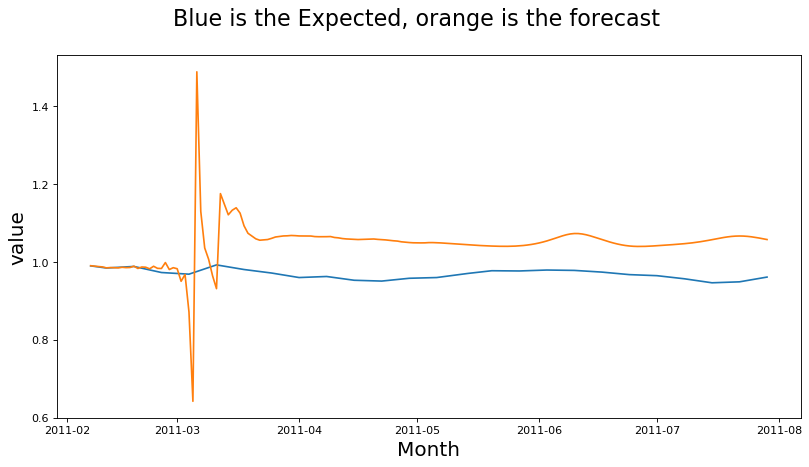

In [60]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 600,'tanh',200)

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 200)               161600    
                                                                 
 dense_55 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
378/378 [==============================] - 4s 7ms/step - loss: 0.0094
Epoch 2/800
378/378 [==============================] - 3s 7ms/step - loss: 0.0028
Epoch 3/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0019
Epoch 4/800
378/378 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 5/800
378/378 [==============================] - 3s 7ms/step - loss: 0.0011
Epoch 6/800
378/378 [============

378/378 [==============================] - 3s 7ms/step - loss: 1.6130e-04
Epoch 181/800
378/378 [==============================] - 3s 7ms/step - loss: 1.6470e-04
Epoch 182/800
378/378 [==============================] - 3s 7ms/step - loss: 1.4189e-04
Epoch 183/800
378/378 [==============================] - 3s 7ms/step - loss: 1.7901e-04
Epoch 184/800
378/378 [==============================] - 3s 7ms/step - loss: 1.8442e-04
Epoch 185/800
378/378 [==============================] - 3s 7ms/step - loss: 1.9467e-04
Epoch 186/800
378/378 [==============================] - 3s 9ms/step - loss: 1.8304e-04
Epoch 187/800
378/378 [==============================] - 3s 7ms/step - loss: 1.6460e-04
Epoch 188/800
378/378 [==============================] - 3s 7ms/step - loss: 1.7793e-04
Epoch 189/800
378/378 [==============================] - 3s 7ms/step - loss: 1.7714e-04
Epoch 190/800
378/378 [==============================] - 3s 7ms/step - loss: 1.8407e-04
Epoch 191/800
378/378 [=======================

378/378 [==============================] - 3s 7ms/step - loss: 1.3813e-04
Epoch 367/800
378/378 [==============================] - 3s 7ms/step - loss: 1.1833e-04
Epoch 368/800
378/378 [==============================] - 3s 7ms/step - loss: 1.3054e-04
Epoch 369/800
378/378 [==============================] - 3s 7ms/step - loss: 1.1205e-04
Epoch 370/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3874e-04
Epoch 371/800
378/378 [==============================] - 3s 7ms/step - loss: 1.2367e-04
Epoch 372/800
378/378 [==============================] - 3s 7ms/step - loss: 1.2145e-04
Epoch 373/800
378/378 [==============================] - 3s 7ms/step - loss: 1.1236e-04
Epoch 374/800
378/378 [==============================] - 3s 7ms/step - loss: 1.1871e-04
Epoch 375/800
378/378 [==============================] - 3s 7ms/step - loss: 1.1185e-04
Epoch 376/800
378/378 [==============================] - 3s 7ms/step - loss: 1.2036e-04
Epoch 377/800
378/378 [=======================

378/378 [==============================] - 3s 7ms/step - loss: 8.4509e-05
Epoch 552/800
378/378 [==============================] - 3s 7ms/step - loss: 8.0015e-05
Epoch 553/800
378/378 [==============================] - 3s 7ms/step - loss: 7.8777e-05
Epoch 554/800
378/378 [==============================] - 3s 7ms/step - loss: 8.8568e-05
Epoch 555/800
378/378 [==============================] - 3s 7ms/step - loss: 7.6685e-05
Epoch 556/800
378/378 [==============================] - 3s 7ms/step - loss: 8.2071e-05
Epoch 557/800
378/378 [==============================] - 3s 7ms/step - loss: 8.4736e-05
Epoch 558/800
378/378 [==============================] - 3s 7ms/step - loss: 8.5639e-05
Epoch 559/800
378/378 [==============================] - 3s 7ms/step - loss: 7.9897e-05
Epoch 560/800
378/378 [==============================] - 3s 7ms/step - loss: 8.7173e-05
Epoch 561/800
378/378 [==============================] - 3s 7ms/step - loss: 9.1514e-05
Epoch 562/800
378/378 [=======================

378/378 [==============================] - 3s 7ms/step - loss: 6.2735e-05
Epoch 737/800
378/378 [==============================] - 3s 7ms/step - loss: 5.8931e-05
Epoch 738/800
378/378 [==============================] - 3s 7ms/step - loss: 5.6696e-05
Epoch 739/800
378/378 [==============================] - 3s 7ms/step - loss: 5.4180e-05
Epoch 740/800
378/378 [==============================] - 3s 7ms/step - loss: 6.1557e-05
Epoch 741/800
378/378 [==============================] - 3s 7ms/step - loss: 5.0386e-05
Epoch 742/800
378/378 [==============================] - 3s 7ms/step - loss: 5.7444e-05
Epoch 743/800
378/378 [==============================] - 3s 7ms/step - loss: 8.6607e-05
Epoch 744/800
378/378 [==============================] - 3s 7ms/step - loss: 5.2618e-05
Epoch 745/800
378/378 [==============================] - 3s 7ms/step - loss: 5.6724e-05
Epoch 746/800
378/378 [==============================] - 3s 7ms/step - loss: 6.1646e-05
Epoch 747/800
378/378 [=======================

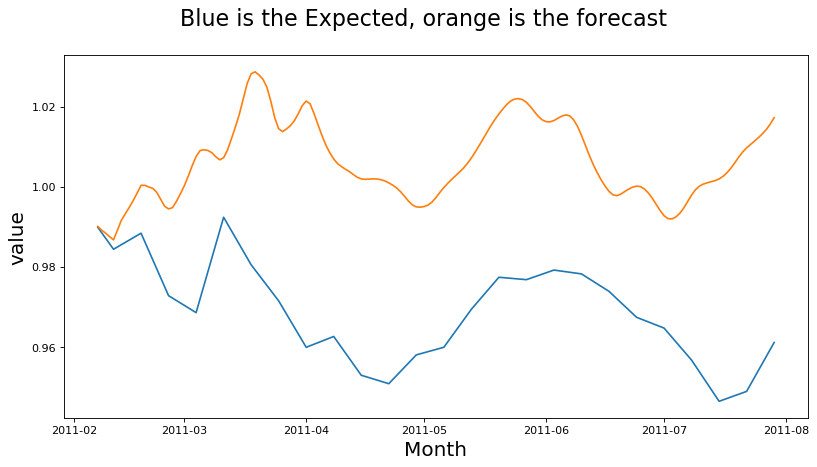

In [64]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 24, 1, 800,'tanh',200)

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 200)               161600    
                                                                 
 dense_56 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
366/366 [==============================] - 4s 9ms/step - loss: 0.0180
Epoch 2/800
366/366 [==============================] - 3s 9ms/step - loss: 0.0075
Epoch 3/800
366/366 [==============================] - 3s 9ms/step - loss: 0.0050
Epoch 4/800
366/366 [==============================] - 3s 9ms/step - loss: 0.0032
Epoch 5/800
366/366 [==============================] - 3s 9ms/step - loss: 0.0022
Epoch 6/800
366/366 [============

366/366 [==============================] - 3s 9ms/step - loss: 2.0590e-04
Epoch 181/800
366/366 [==============================] - 3s 9ms/step - loss: 1.9028e-04
Epoch 182/800
366/366 [==============================] - 4s 10ms/step - loss: 1.7879e-04
Epoch 183/800
366/366 [==============================] - 3s 9ms/step - loss: 1.8463e-04
Epoch 184/800
366/366 [==============================] - 3s 9ms/step - loss: 2.0947e-04
Epoch 185/800
366/366 [==============================] - 3s 9ms/step - loss: 1.9517e-04
Epoch 186/800
366/366 [==============================] - 3s 9ms/step - loss: 2.1602e-04
Epoch 187/800
366/366 [==============================] - 3s 9ms/step - loss: 2.2025e-04
Epoch 188/800
366/366 [==============================] - 3s 9ms/step - loss: 1.9239e-04
Epoch 189/800
366/366 [==============================] - 3s 9ms/step - loss: 2.0661e-04
Epoch 190/800
366/366 [==============================] - 3s 9ms/step - loss: 1.9120e-04
Epoch 191/800
366/366 [======================

Epoch 273/800
366/366 [==============================] - 3s 9ms/step - loss: 1.8260e-04
Epoch 274/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5657e-04
Epoch 275/800
366/366 [==============================] - 3s 9ms/step - loss: 1.6968e-04
Epoch 276/800
366/366 [==============================] - 3s 9ms/step - loss: 1.6681e-04
Epoch 277/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5485e-04
Epoch 278/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5452e-04
Epoch 279/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5054e-04
Epoch 280/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5792e-04
Epoch 281/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4993e-04
Epoch 282/800
366/366 [==============================] - 3s 9ms/step - loss: 1.6973e-04
Epoch 283/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4974e-04
Epoch 284/800
366/366 [=========

366/366 [==============================] - 3s 9ms/step - loss: 1.3858e-04
Epoch 367/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4830e-04
Epoch 368/800
366/366 [==============================] - 3s 9ms/step - loss: 1.2336e-04
Epoch 369/800
366/366 [==============================] - 3s 9ms/step - loss: 1.2820e-04
Epoch 370/800
366/366 [==============================] - 3s 9ms/step - loss: 1.3335e-04
Epoch 371/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4069e-04
Epoch 372/800
366/366 [==============================] - 3s 9ms/step - loss: 1.5934e-04
Epoch 373/800
366/366 [==============================] - 3s 9ms/step - loss: 1.2754e-04
Epoch 374/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4436e-04
Epoch 375/800
366/366 [==============================] - 3s 9ms/step - loss: 1.1403e-04
Epoch 376/800
366/366 [==============================] - 3s 9ms/step - loss: 1.4705e-04
Epoch 377/800
366/366 [=======================

366/366 [==============================] - 3s 9ms/step - loss: 9.0281e-05
Epoch 553/800
366/366 [==============================] - 3s 9ms/step - loss: 8.4504e-05
Epoch 554/800
366/366 [==============================] - 3s 9ms/step - loss: 9.8157e-05
Epoch 555/800
366/366 [==============================] - 3s 9ms/step - loss: 9.6256e-05
Epoch 556/800
366/366 [==============================] - 3s 9ms/step - loss: 8.9039e-05
Epoch 557/800
366/366 [==============================] - 3s 9ms/step - loss: 8.3738e-05
Epoch 558/800
366/366 [==============================] - 3s 9ms/step - loss: 1.0480e-04
Epoch 559/800
366/366 [==============================] - 3s 9ms/step - loss: 9.7283e-05
Epoch 560/800
366/366 [==============================] - 3s 9ms/step - loss: 8.6695e-05
Epoch 561/800
366/366 [==============================] - 3s 9ms/step - loss: 9.2962e-05
Epoch 562/800
366/366 [==============================] - 3s 9ms/step - loss: 7.7921e-05
Epoch 563/800
366/366 [=======================

366/366 [==============================] - 3s 9ms/step - loss: 7.4668e-05
Epoch 739/800
366/366 [==============================] - 3s 9ms/step - loss: 6.4836e-05
Epoch 740/800
366/366 [==============================] - 3s 9ms/step - loss: 6.0804e-05
Epoch 741/800
366/366 [==============================] - 3s 9ms/step - loss: 5.5466e-05
Epoch 742/800
366/366 [==============================] - 3s 9ms/step - loss: 6.6673e-05
Epoch 743/800
366/366 [==============================] - 3s 9ms/step - loss: 6.8805e-05
Epoch 744/800
366/366 [==============================] - 3s 9ms/step - loss: 6.9495e-05
Epoch 745/800
366/366 [==============================] - 3s 9ms/step - loss: 5.4676e-05
Epoch 746/800
366/366 [==============================] - 3s 9ms/step - loss: 7.4882e-05
Epoch 747/800
366/366 [==============================] - 3s 9ms/step - loss: 6.2762e-05
Epoch 748/800
366/366 [==============================] - 3s 9ms/step - loss: 6.8822e-05
Epoch 749/800
366/366 [=======================

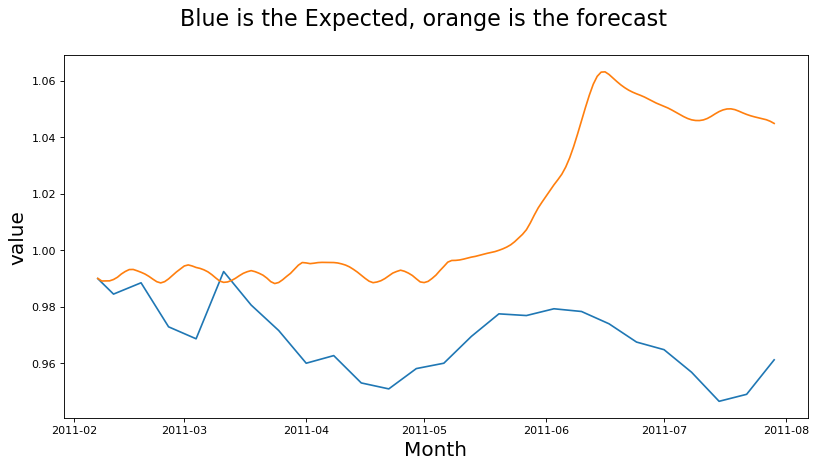

In [65]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 800,'relu',200)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 200)               161600    
                                                                 
 dense_57 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
366/366 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 2/800
366/366 [==============================] - 3s 9ms/step - loss: 0.0041
Epoch 3/800
366/366 [==============================] - 4s 10ms/step - loss: 0.0018
Epoch 4/800
366/366 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 5/800
366/366 [==============================] - 4s 10ms/step - loss: 9.3721e-04
Epoch 6/800
366/366 [====

366/366 [==============================] - 4s 10ms/step - loss: 1.7449e-04
Epoch 177/800
366/366 [==============================] - 4s 10ms/step - loss: 1.7723e-04
Epoch 178/800
366/366 [==============================] - 4s 10ms/step - loss: 1.6098e-04
Epoch 179/800
366/366 [==============================] - 4s 10ms/step - loss: 1.6036e-04
Epoch 180/800
366/366 [==============================] - 4s 10ms/step - loss: 1.5542e-04
Epoch 181/800
366/366 [==============================] - 4s 10ms/step - loss: 1.7568e-04
Epoch 182/800
366/366 [==============================] - 4s 10ms/step - loss: 1.9433e-04
Epoch 183/800
366/366 [==============================] - 4s 10ms/step - loss: 1.6825e-04
Epoch 184/800
366/366 [==============================] - 4s 10ms/step - loss: 1.5861e-04
Epoch 185/800
366/366 [==============================] - 4s 10ms/step - loss: 1.7125e-04
Epoch 186/800
366/366 [==============================] - 4s 10ms/step - loss: 1.5714e-04
Epoch 187/800
366/366 [============

Epoch 268/800
366/366 [==============================] - 4s 10ms/step - loss: 1.3780e-04
Epoch 269/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4997e-04
Epoch 270/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4786e-04
Epoch 271/800
366/366 [==============================] - 4s 10ms/step - loss: 1.5237e-04
Epoch 272/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4698e-04
Epoch 273/800
366/366 [==============================] - 4s 10ms/step - loss: 1.5052e-04
Epoch 274/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4167e-04
Epoch 275/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4369e-04: 0s - loss: 1.4568e-
Epoch 276/800
366/366 [==============================] - 4s 10ms/step - loss: 1.3832e-04
Epoch 277/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4472e-04
Epoch 278/800
366/366 [==============================] - 4s 10ms/step - loss: 1.4338e-04


366/366 [==============================] - 4s 10ms/step - loss: 1.2187e-04
Epoch 360/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1687e-04
Epoch 361/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0402e-04
Epoch 362/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1481e-04
Epoch 363/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1212e-04
Epoch 364/800
366/366 [==============================] - 4s 10ms/step - loss: 1.3696e-04
Epoch 365/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1000e-04
Epoch 366/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0685e-04
Epoch 367/800
366/366 [==============================] - 4s 10ms/step - loss: 1.2393e-04
Epoch 368/800
366/366 [==============================] - 4s 10ms/step - loss: 9.6850e-05
Epoch 369/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1652e-04
Epoch 370/800
366/366 [============

366/366 [==============================] - 4s 10ms/step - loss: 8.1611e-05
Epoch 452/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0069e-04
Epoch 453/800
366/366 [==============================] - 4s 10ms/step - loss: 8.8010e-05
Epoch 454/800
366/366 [==============================] - 4s 11ms/step - loss: 1.0628e-04
Epoch 455/800
366/366 [==============================] - 4s 10ms/step - loss: 9.6899e-05
Epoch 456/800
366/366 [==============================] - 4s 10ms/step - loss: 8.5724e-05
Epoch 457/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0205e-04
Epoch 458/800
366/366 [==============================] - 4s 10ms/step - loss: 9.4815e-05
Epoch 459/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0215e-04
Epoch 460/800
366/366 [==============================] - 4s 10ms/step - loss: 8.8730e-05
Epoch 461/800
366/366 [==============================] - 4s 10ms/step - loss: 8.3813e-05
Epoch 462/800
366/366 [============

Epoch 634/800
366/366 [==============================] - 4s 10ms/step - loss: 6.0393e-05
Epoch 635/800
366/366 [==============================] - 4s 10ms/step - loss: 6.2392e-05
Epoch 636/800
366/366 [==============================] - 4s 10ms/step - loss: 6.0173e-05
Epoch 637/800
366/366 [==============================] - 4s 10ms/step - loss: 7.9203e-05
Epoch 638/800
366/366 [==============================] - 4s 10ms/step - loss: 5.4041e-05
Epoch 639/800
366/366 [==============================] - 4s 10ms/step - loss: 5.3888e-05
Epoch 640/800
366/366 [==============================] - 4s 10ms/step - loss: 6.7683e-05
Epoch 641/800
366/366 [==============================] - 4s 10ms/step - loss: 6.5071e-05
Epoch 642/800
366/366 [==============================] - 4s 10ms/step - loss: 8.1244e-05
Epoch 643/800
366/366 [==============================] - 4s 10ms/step - loss: 1.0100e-04
Epoch 644/800
366/366 [==============================] - 4s 10ms/step - loss: 1.1622e-04: 1s
Epoch 645/800
366

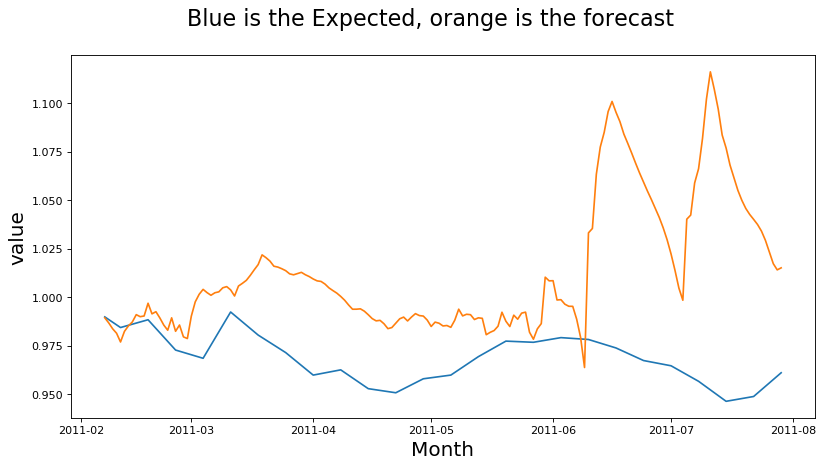

In [66]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 36, 1, 800,'tanh',200)

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 200)               161600    
                                                                 
 dense_61 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
342/342 [==============================] - 6s 15ms/step - loss: 0.0100
Epoch 2/800
342/342 [==============================] - 5s 15ms/step - loss: 0.0022
Epoch 3/800
342/342 [==============================] - 5s 15ms/step - loss: 0.0013
Epoch 4/800
342/342 [==============================] - 5s 15ms/step - loss: 0.0011
Epoch 5/800
342/342 [==============================] - 5s 15ms/step - loss: 8.7271e-04
Epoch 6/800
342/342 [===

Epoch 85/800
342/342 [==============================] - 5s 15ms/step - loss: 2.8141e-04
Epoch 86/800
342/342 [==============================] - 5s 15ms/step - loss: 2.6635e-04
Epoch 87/800
342/342 [==============================] - 5s 15ms/step - loss: 2.7595e-04 ETA: 1
Epoch 88/800
342/342 [==============================] - 5s 15ms/step - loss: 2.5923e-04
Epoch 89/800
342/342 [==============================] - 5s 15ms/step - loss: 2.5401e-04
Epoch 90/800
342/342 [==============================] - 5s 15ms/step - loss: 2.8493e-04
Epoch 91/800
342/342 [==============================] - 5s 15ms/step - loss: 3.3863e-04
Epoch 92/800
342/342 [==============================] - 5s 15ms/step - loss: 2.3986e-04
Epoch 93/800
342/342 [==============================] - 5s 15ms/step - loss: 2.3710e-04
Epoch 94/800
342/342 [==============================] - 5s 15ms/step - loss: 2.5265e-04: 1s - ETA: 0s - loss: 
Epoch 95/800
342/342 [==============================] - 5s 15ms/step - loss: 2.3135e-04:  

342/342 [==============================] - 5s 15ms/step - loss: 1.5334e-04
Epoch 267/800
342/342 [==============================] - 5s 15ms/step - loss: 1.4490e-04: 4s - loss: 2.4505e-0 - ETA: 4s - - ETA: 
Epoch 268/800
342/342 [==============================] - 5s 15ms/step - loss: 1.4698e-04
Epoch 269/800
342/342 [==============================] - 5s 15ms/step - loss: 1.3385e-04: 0s - loss: 1. - ETA: 0s - loss: 1.3193e-0
Epoch 270/800
342/342 [==============================] - 5s 15ms/step - loss: 1.7143e-04
Epoch 271/800
342/342 [==============================] - 5s 15ms/step - loss: 1.3662e-04
Epoch 272/800
342/342 [==============================] - 5s 15ms/step - loss: 1.2963e-04
Epoch 273/800
342/342 [==============================] - 5s 15ms/step - loss: 1.3921e-04
Epoch 274/800
342/342 [==============================] - 5s 15ms/step - loss: 1.4059e-04
Epoch 275/800
342/342 [==============================] - 5s 15ms/step - loss: 1.4642e-04
Epoch 276/800
342/342 [================

342/342 [==============================] - 5s 15ms/step - loss: 1.3609e-04: 0s - loss: 1.40
Epoch 446/800
342/342 [==============================] - 5s 15ms/step - loss: 1.1019e-04
Epoch 447/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0712e-04
Epoch 448/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0555e-04
Epoch 449/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0983e-04
Epoch 450/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0689e-04: 1s 
Epoch 451/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0323e-04: 0s - loss: 1.0636
Epoch 452/800
342/342 [==============================] - 5s 15ms/step - loss: 9.8089e-05
Epoch 453/800
342/342 [==============================] - 5s 15ms/step - loss: 1.0636e-04
Epoch 454/800
342/342 [==============================] - 5s 15ms/step - loss: 1.2068e-04
Epoch 455/800
342/342 [==============================] - 5s 15ms/step - loss: 1.159

342/342 [==============================] - 5s 15ms/step - loss: 8.2749e-05: 0s - loss
Epoch 625/800
342/342 [==============================] - 5s 15ms/step - loss: 9.5675e-05
Epoch 626/800
342/342 [==============================] - 5s 15ms/step - loss: 8.3201e-05
Epoch 627/800
342/342 [==============================] - 5s 15ms/step - loss: 8.6624e-05
Epoch 628/800
342/342 [==============================] - 5s 15ms/step - loss: 7.8676e-05
Epoch 629/800
342/342 [==============================] - 5s 15ms/step - loss: 9.0377e-05: 0s - loss: 
Epoch 630/800
342/342 [==============================] - 5s 15ms/step - loss: 7.7223e-05
Epoch 631/800
342/342 [==============================] - 5s 15ms/step - loss: 9.7628e-05
Epoch 632/800
342/342 [==============================] - 5s 15ms/step - loss: 9.0772e-05
Epoch 633/800
342/342 [==============================] - 5s 15ms/step - loss: 7.8169e-05
Epoch 634/800
342/342 [==============================] - 5s 16ms/step - loss: 8.2763e-05
Epoch 635/8

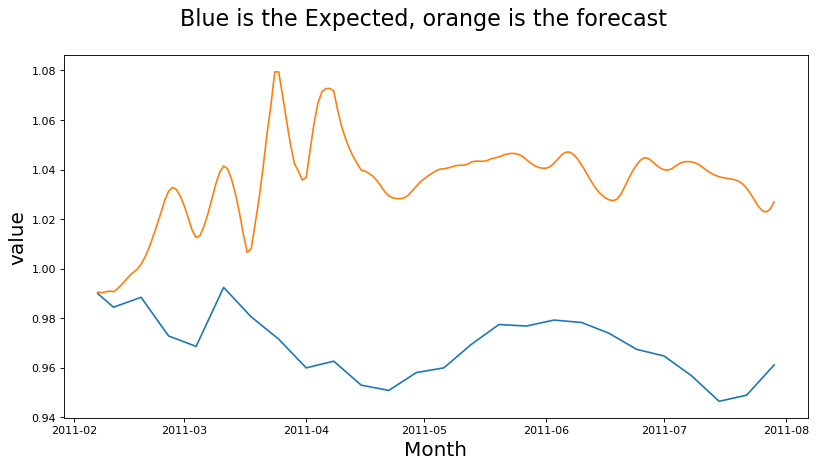

In [70]:
model_USD_CAD = train_RNN(train_USD_CAD,test_USD_CAD, 60, 1, 800,'tanh',200)

## Training and Test Sets

We must divide our time series into a training and test sample. Since our series has anual seasonality, let's leave the last yeas as test sample and the rest of the series as training.

The size of the test series is the size of the largest forecast horizon.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
378/378 [==============================] - 4s 8ms/step - loss: 0.0076
Epoch 2/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0026
Epoch 3/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 4/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 5/800
378/378 [==============================] - 3s 8ms/step - loss: 8.4884e-04
Epoch 6/800
378/378 [=========

378/378 [==============================] - 3s 8ms/step - loss: 2.7917e-04
Epoch 88/800
378/378 [==============================] - 3s 8ms/step - loss: 2.7730e-04
Epoch 89/800
378/378 [==============================] - 3s 8ms/step - loss: 2.6064e-04
Epoch 90/800
378/378 [==============================] - 3s 8ms/step - loss: 3.0953e-04
Epoch 91/800
378/378 [==============================] - 3s 8ms/step - loss: 2.9543e-04
Epoch 92/800
378/378 [==============================] - 3s 8ms/step - loss: 2.4620e-04
Epoch 93/800
378/378 [==============================] - 3s 8ms/step - loss: 2.4224e-04
Epoch 94/800
378/378 [==============================] - 3s 8ms/step - loss: 2.5814e-04
Epoch 95/800
378/378 [==============================] - 3s 8ms/step - loss: 2.5753e-04
Epoch 96/800
378/378 [==============================] - 3s 8ms/step - loss: 2.6448e-04
Epoch 97/800
378/378 [==============================] - 3s 8ms/step - loss: 2.6421e-04
Epoch 98/800
378/378 [==============================] - 

378/378 [==============================] - 3s 8ms/step - loss: 1.8983e-04
Epoch 181/800
378/378 [==============================] - 3s 8ms/step - loss: 2.0913e-04
Epoch 182/800
378/378 [==============================] - 3s 8ms/step - loss: 1.8634e-04
Epoch 183/800
378/378 [==============================] - 3s 8ms/step - loss: 1.9432e-04
Epoch 184/800
378/378 [==============================] - 3s 8ms/step - loss: 1.8947e-04
Epoch 185/800
378/378 [==============================] - 3s 8ms/step - loss: 1.6970e-04
Epoch 186/800
378/378 [==============================] - 3s 8ms/step - loss: 1.9660e-04
Epoch 187/800
378/378 [==============================] - 3s 8ms/step - loss: 1.7559e-04
Epoch 188/800
378/378 [==============================] - 3s 8ms/step - loss: 1.9512e-04
Epoch 189/800
378/378 [==============================] - 3s 8ms/step - loss: 1.8141e-04
Epoch 190/800
378/378 [==============================] - 3s 8ms/step - loss: 1.8146e-04
Epoch 191/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 1.5302e-04
Epoch 274/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4126e-04
Epoch 275/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4416e-04
Epoch 276/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3221e-04
Epoch 277/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3480e-04
Epoch 278/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3930e-04
Epoch 279/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4794e-04
Epoch 280/800
378/378 [==============================] - 3s 7ms/step - loss: 1.2545e-04
Epoch 281/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3663e-04
Epoch 282/800
378/378 [==============================] - 3s 7ms/step - loss: 1.2986e-04
Epoch 283/800
378/378 [==============================] - 3s 7ms/step - loss: 1.4064e-04
Epoch 284/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 1.0925e-04
Epoch 366/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1562e-04
Epoch 367/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2544e-04
Epoch 368/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2123e-04
Epoch 369/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2124e-04
Epoch 370/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2269e-04
Epoch 371/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4111e-04
Epoch 372/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2325e-04
Epoch 373/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1780e-04
Epoch 374/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1407e-04
Epoch 375/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1373e-04
Epoch 376/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 1.1228e-04
Epoch 459/800
378/378 [==============================] - 3s 8ms/step - loss: 9.9591e-05
Epoch 460/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0381e-04
Epoch 461/800
378/378 [==============================] - 3s 8ms/step - loss: 9.5693e-05
Epoch 462/800
378/378 [==============================] - 3s 8ms/step - loss: 9.0582e-05
Epoch 463/800
378/378 [==============================] - 3s 8ms/step - loss: 9.7284e-05
Epoch 464/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0596e-04
Epoch 465/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0990e-04
Epoch 466/800
378/378 [==============================] - 3s 8ms/step - loss: 9.5300e-05
Epoch 467/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0670e-04
Epoch 468/800
378/378 [==============================] - 3s 8ms/step - loss: 9.6195e-05
Epoch 469/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 9.2519e-05
Epoch 551/800
378/378 [==============================] - 3s 8ms/step - loss: 8.8730e-05
Epoch 552/800
378/378 [==============================] - 3s 8ms/step - loss: 8.0620e-05
Epoch 553/800
378/378 [==============================] - 3s 8ms/step - loss: 8.5888e-05
Epoch 554/800
378/378 [==============================] - 3s 8ms/step - loss: 8.7164e-05
Epoch 555/800
378/378 [==============================] - 3s 8ms/step - loss: 8.5481e-05
Epoch 556/800
378/378 [==============================] - 3s 8ms/step - loss: 8.1866e-05
Epoch 557/800
378/378 [==============================] - 3s 8ms/step - loss: 8.0097e-05
Epoch 558/800
378/378 [==============================] - 3s 8ms/step - loss: 8.5050e-05
Epoch 559/800
378/378 [==============================] - 3s 8ms/step - loss: 9.1558e-05
Epoch 560/800
378/378 [==============================] - 3s 8ms/step - loss: 8.5617e-05
Epoch 561/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 7.9653e-05
Epoch 644/800
378/378 [==============================] - 3s 8ms/step - loss: 9.2245e-05
Epoch 645/800
378/378 [==============================] - 3s 8ms/step - loss: 7.6449e-05
Epoch 646/800
378/378 [==============================] - 3s 8ms/step - loss: 6.1942e-05
Epoch 647/800
378/378 [==============================] - 3s 9ms/step - loss: 6.2160e-05
Epoch 648/800
378/378 [==============================] - 3s 8ms/step - loss: 7.5934e-05
Epoch 649/800
378/378 [==============================] - 3s 8ms/step - loss: 6.9524e-05
Epoch 650/800
378/378 [==============================] - 3s 8ms/step - loss: 6.8015e-05
Epoch 651/800
378/378 [==============================] - ETA: 0s - loss: 6.9260e-0 - 3s 8ms/step - loss: 6.9300e-05
Epoch 652/800
378/378 [==============================] - 3s 8ms/step - loss: 6.1925e-05
Epoch 653/800
378/378 [==============================] - 3s 8ms/step - loss: 6.2808e-05
Epoch 654/800
378/

378/378 [==============================] - 3s 9ms/step - loss: 9.7888e-05
Epoch 736/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6211e-05
Epoch 737/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6639e-05
Epoch 738/800
378/378 [==============================] - 3s 8ms/step - loss: 5.1383e-05
Epoch 739/800
378/378 [==============================] - 3s 8ms/step - loss: 4.8514e-05
Epoch 740/800
378/378 [==============================] - 3s 8ms/step - loss: 5.1953e-05
Epoch 741/800
378/378 [==============================] - 3s 8ms/step - loss: 5.2854e-05
Epoch 742/800
378/378 [==============================] - 3s 8ms/step - loss: 6.1321e-05
Epoch 743/800
378/378 [==============================] - 3s 8ms/step - loss: 5.8518e-05
Epoch 744/800
378/378 [==============================] - 3s 8ms/step - loss: 5.2896e-05
Epoch 745/800
378/378 [==============================] - 3s 8ms/step - loss: 4.7317e-05
Epoch 746/800
378/378 [=======================

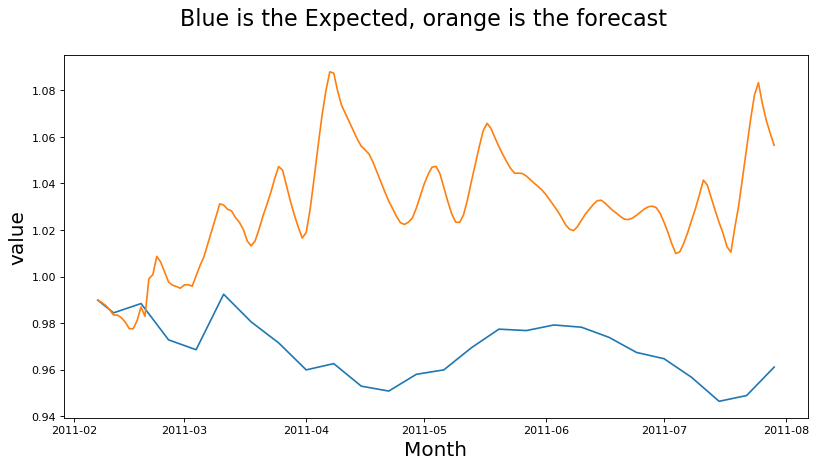

In [10]:
model_USD_CAD = train_RNN_with_Error(train_USD_CAD,test_USD_CAD, 24, 1, 800,'tanh',200)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
378/378 [==============================] - 5s 9ms/step - loss: 0.0083
Epoch 2/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0027
Epoch 3/800
378/378 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 4/800
378/378 [==============================] - 3s 8ms/step - loss: 8.7421e-04
Epoch 5/800
378/378 [==============================] - 3s 8ms/step - loss: 6.0592e-04
Epoch 6/800
378/378 [=====

378/378 [==============================] - 3s 8ms/step - loss: 1.4768e-04
Epoch 88/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2364e-04
Epoch 89/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3757e-04
Epoch 90/800
378/378 [==============================] - 3s 8ms/step - loss: 1.3797e-04
Epoch 91/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1456e-04
Epoch 92/800
378/378 [==============================] - 3s 8ms/step - loss: 1.2730e-04
Epoch 93/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4788e-04
Epoch 94/800
378/378 [==============================] - 3s 8ms/step - loss: 1.6484e-04
Epoch 95/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1824e-04
Epoch 96/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1696e-04
Epoch 97/800
378/378 [==============================] - 3s 8ms/step - loss: 1.4236e-04
Epoch 98/800
378/378 [==============================] - 

378/378 [==============================] - 3s 8ms/step - loss: 9.8876e-05
Epoch 181/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1666e-04
Epoch 182/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0767e-04
Epoch 183/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0206e-04
Epoch 184/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0084e-04
Epoch 185/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1343e-04
Epoch 186/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1174e-04
Epoch 187/800
378/378 [==============================] - 3s 8ms/step - loss: 9.7580e-05
Epoch 188/800
378/378 [==============================] - 3s 8ms/step - loss: 1.0382e-04
Epoch 189/800
378/378 [==============================] - 3s 8ms/step - loss: 1.1447e-04
Epoch 190/800
378/378 [==============================] - 3s 8ms/step - loss: 9.8409e-05
Epoch 191/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 7.1757e-05
Epoch 274/800
378/378 [==============================] - 3s 8ms/step - loss: 6.5992e-05
Epoch 275/800
378/378 [==============================] - 3s 8ms/step - loss: 6.3485e-05
Epoch 276/800
378/378 [==============================] - 3s 8ms/step - loss: 6.5844e-05
Epoch 277/800
378/378 [==============================] - 3s 8ms/step - loss: 6.5213e-05
Epoch 278/800
378/378 [==============================] - 3s 8ms/step - loss: 6.8274e-05
Epoch 279/800
378/378 [==============================] - 3s 8ms/step - loss: 6.8943e-05
Epoch 280/800
378/378 [==============================] - 3s 8ms/step - loss: 5.8085e-05
Epoch 281/800
378/378 [==============================] - 3s 8ms/step - loss: 6.7545e-05
Epoch 282/800
378/378 [==============================] - 3s 8ms/step - loss: 6.9583e-05
Epoch 283/800
378/378 [==============================] - 3s 8ms/step - loss: 6.8223e-05
Epoch 284/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 5.9642e-05
Epoch 367/800
378/378 [==============================] - 3s 8ms/step - loss: 5.7412e-05
Epoch 368/800
378/378 [==============================] - 3s 8ms/step - loss: 5.5810e-05
Epoch 369/800
378/378 [==============================] - 3s 8ms/step - loss: 5.0242e-05
Epoch 370/800
378/378 [==============================] - 3s 8ms/step - loss: 5.5630e-05
Epoch 371/800
378/378 [==============================] - 3s 8ms/step - loss: 6.1185e-05
Epoch 372/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6785e-05
Epoch 373/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6115e-05
Epoch 374/800
378/378 [==============================] - 3s 8ms/step - loss: 5.9650e-05
Epoch 375/800
378/378 [==============================] - 3s 8ms/step - loss: 5.8905e-05
Epoch 376/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6296e-05
Epoch 377/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 5.2679e-05
Epoch 460/800
378/378 [==============================] - 3s 8ms/step - loss: 6.5981e-05
Epoch 461/800
378/378 [==============================] - 3s 8ms/step - loss: 5.1464e-05
Epoch 462/800
378/378 [==============================] - 3s 8ms/step - loss: 5.5036e-05
Epoch 463/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6961e-05
Epoch 464/800
378/378 [==============================] - 3s 8ms/step - loss: 4.6545e-05
Epoch 465/800
378/378 [==============================] - 3s 8ms/step - loss: 5.3813e-05
Epoch 466/800
378/378 [==============================] - 3s 8ms/step - loss: 4.4402e-05
Epoch 467/800
378/378 [==============================] - 3s 8ms/step - loss: 4.9193e-05
Epoch 468/800
378/378 [==============================] - 3s 8ms/step - loss: 5.6263e-05
Epoch 469/800
378/378 [==============================] - 3s 8ms/step - loss: 4.9390e-05
Epoch 470/800
378/378 [=======================

378/378 [==============================] - 3s 8ms/step - loss: 4.2568e-05
Epoch 553/800
378/378 [==============================] - 3s 8ms/step - loss: 4.3952e-05
Epoch 554/800
378/378 [==============================] - 3s 8ms/step - loss: 4.5410e-05
Epoch 555/800
378/378 [==============================] - 3s 8ms/step - loss: 4.1146e-05
Epoch 556/800
378/378 [==============================] - 3s 8ms/step - loss: 4.9050e-05
Epoch 557/800
378/378 [==============================] - 3s 8ms/step - loss: 4.6475e-05
Epoch 558/800
378/378 [==============================] - 3s 8ms/step - loss: 4.8826e-05
Epoch 559/800
378/378 [==============================] - 3s 8ms/step - loss: 4.7773e-05
Epoch 560/800
378/378 [==============================] - 3s 8ms/step - loss: 4.9217e-05
Epoch 561/800
378/378 [==============================] - 3s 8ms/step - loss: 4.7859e-05
Epoch 562/800
378/378 [==============================] - 3s 8ms/step - loss: 5.1718e-05
Epoch 563/800
378/378 [=======================

378/378 [==============================] - 3s 9ms/step - loss: 3.9836e-05
Epoch 646/800
378/378 [==============================] - 3s 9ms/step - loss: 4.1235e-05
Epoch 647/800
378/378 [==============================] - 3s 9ms/step - loss: 4.9527e-05
Epoch 648/800
378/378 [==============================] - 3s 9ms/step - loss: 4.6651e-05
Epoch 649/800
378/378 [==============================] - 3s 9ms/step - loss: 4.2959e-05
Epoch 650/800
378/378 [==============================] - 3s 9ms/step - loss: 4.0275e-05
Epoch 651/800
378/378 [==============================] - 3s 9ms/step - loss: 4.4275e-05
Epoch 652/800
378/378 [==============================] - 3s 9ms/step - loss: 4.1634e-05
Epoch 653/800
378/378 [==============================] - 3s 9ms/step - loss: 4.3364e-05
Epoch 654/800
378/378 [==============================] - 3s 9ms/step - loss: 3.6173e-05
Epoch 655/800
378/378 [==============================] - 3s 9ms/step - loss: 4.2238e-05
Epoch 656/800
378/378 [=======================

378/378 [==============================] - 3s 9ms/step - loss: 3.2189e-05
Epoch 739/800
378/378 [==============================] - 3s 9ms/step - loss: 3.8779e-05
Epoch 740/800
378/378 [==============================] - 3s 9ms/step - loss: 4.0838e-05
Epoch 741/800
378/378 [==============================] - 3s 9ms/step - loss: 3.5613e-05
Epoch 742/800
378/378 [==============================] - 3s 9ms/step - loss: 4.0255e-05
Epoch 743/800
378/378 [==============================] - 3s 9ms/step - loss: 3.7995e-05
Epoch 744/800
378/378 [==============================] - 3s 9ms/step - loss: 4.5528e-05
Epoch 745/800
378/378 [==============================] - 3s 9ms/step - loss: 3.4658e-05
Epoch 746/800
378/378 [==============================] - 3s 9ms/step - loss: 3.8323e-05
Epoch 747/800
378/378 [==============================] - 3s 9ms/step - loss: 3.5348e-05
Epoch 748/800
378/378 [==============================] - 3s 9ms/step - loss: 3.5060e-05
Epoch 749/800
378/378 [=======================

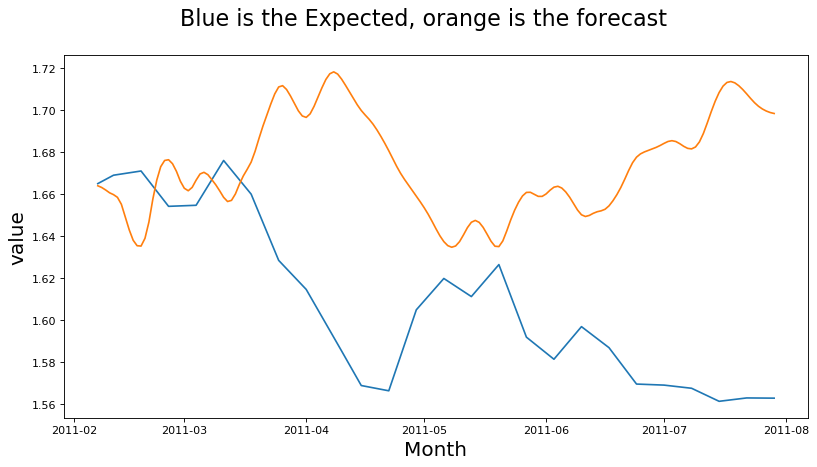

In [11]:
model_USD_BRL = train_RNN(train_USD_BRL,test_USD_BRL, 24, 1, 800,'tanh',200)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
342/342 [==============================] - 5s 9ms/step - loss: 0.0069
Epoch 2/800
342/342 [==============================] - 3s 9ms/step - loss: 0.0022
Epoch 3/800
342/342 [==============================] - 3s 9ms/step - loss: 0.0015
Epoch 4/800
342/342 [==============================] - 3s 9ms/step - loss: 8.8896e-04
Epoch 5/800
342/342 [==============================] - 3s 9ms/step - loss: 7.3895e-04
Epoch 6/800
342/342 [=====

342/342 [==============================] - 3s 9ms/step - loss: 1.0738e-04
Epoch 88/800
342/342 [==============================] - 3s 9ms/step - loss: 1.0287e-04
Epoch 89/800
342/342 [==============================] - 3s 9ms/step - loss: 1.0390e-04
Epoch 90/800
342/342 [==============================] - 3s 9ms/step - loss: 9.7242e-05
Epoch 91/800
342/342 [==============================] - 3s 9ms/step - loss: 9.5373e-05
Epoch 92/800
342/342 [==============================] - 3s 9ms/step - loss: 9.1305e-05
Epoch 93/800
342/342 [==============================] - 3s 9ms/step - loss: 9.9455e-05
Epoch 94/800
342/342 [==============================] - 3s 9ms/step - loss: 8.7665e-05
Epoch 95/800
342/342 [==============================] - 3s 9ms/step - loss: 9.2672e-05
Epoch 96/800
342/342 [==============================] - 3s 9ms/step - loss: 9.0500e-05
Epoch 97/800
342/342 [==============================] - 3s 9ms/step - loss: 8.2285e-05
Epoch 98/800
342/342 [==============================] - 

342/342 [==============================] - 3s 9ms/step - loss: 8.5014e-05
Epoch 181/800
342/342 [==============================] - 3s 9ms/step - loss: 7.8087e-05
Epoch 182/800
342/342 [==============================] - 3s 9ms/step - loss: 8.0584e-05
Epoch 183/800
342/342 [==============================] - 3s 9ms/step - loss: 8.5792e-05
Epoch 184/800
342/342 [==============================] - 3s 9ms/step - loss: 7.5492e-05
Epoch 185/800
342/342 [==============================] - 3s 9ms/step - loss: 8.3041e-05
Epoch 186/800
342/342 [==============================] - 3s 9ms/step - loss: 7.7068e-05
Epoch 187/800
342/342 [==============================] - 3s 9ms/step - loss: 8.2417e-05
Epoch 188/800
342/342 [==============================] - 3s 9ms/step - loss: 9.5233e-05
Epoch 189/800
342/342 [==============================] - 3s 9ms/step - loss: 8.0319e-05
Epoch 190/800
342/342 [==============================] - 3s 9ms/step - loss: 8.5371e-05
Epoch 191/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 8.1426e-05
Epoch 274/800
342/342 [==============================] - 3s 9ms/step - loss: 7.3910e-05
Epoch 275/800
342/342 [==============================] - 3s 9ms/step - loss: 6.5528e-05
Epoch 276/800
342/342 [==============================] - 3s 9ms/step - loss: 7.9918e-05
Epoch 277/800
342/342 [==============================] - 3s 9ms/step - loss: 8.3495e-05
Epoch 278/800
342/342 [==============================] - 3s 9ms/step - loss: 8.1787e-05
Epoch 279/800
342/342 [==============================] - 3s 9ms/step - loss: 8.1597e-05
Epoch 280/800
342/342 [==============================] - 3s 9ms/step - loss: 7.1710e-05
Epoch 281/800
342/342 [==============================] - 3s 9ms/step - loss: 8.7509e-05
Epoch 282/800
342/342 [==============================] - 3s 9ms/step - loss: 6.8624e-05
Epoch 283/800
342/342 [==============================] - 3s 9ms/step - loss: 7.2491e-05
Epoch 284/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 6.3327e-05
Epoch 367/800
342/342 [==============================] - 3s 9ms/step - loss: 6.5863e-05
Epoch 368/800
342/342 [==============================] - 3s 9ms/step - loss: 7.3174e-05
Epoch 369/800
342/342 [==============================] - 3s 9ms/step - loss: 6.0515e-05
Epoch 370/800
342/342 [==============================] - 3s 9ms/step - loss: 6.4734e-05
Epoch 371/800
342/342 [==============================] - 3s 9ms/step - loss: 6.0242e-05
Epoch 372/800
342/342 [==============================] - 3s 9ms/step - loss: 6.3090e-05
Epoch 373/800
342/342 [==============================] - 3s 9ms/step - loss: 5.9305e-05
Epoch 374/800
342/342 [==============================] - 3s 9ms/step - loss: 6.4497e-05
Epoch 375/800
342/342 [==============================] - 3s 9ms/step - loss: 7.0655e-05
Epoch 376/800
342/342 [==============================] - 3s 9ms/step - loss: 6.1654e-05
Epoch 377/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 5.6861e-05
Epoch 460/800
342/342 [==============================] - 3s 9ms/step - loss: 4.9230e-05
Epoch 461/800
342/342 [==============================] - 3s 9ms/step - loss: 5.3066e-05
Epoch 462/800
342/342 [==============================] - 3s 9ms/step - loss: 4.5519e-05
Epoch 463/800
342/342 [==============================] - 3s 9ms/step - loss: 5.1140e-05
Epoch 464/800
342/342 [==============================] - 3s 9ms/step - loss: 5.8379e-05
Epoch 465/800
342/342 [==============================] - 3s 9ms/step - loss: 5.4642e-05
Epoch 466/800
342/342 [==============================] - 3s 9ms/step - loss: 5.1122e-05
Epoch 467/800
342/342 [==============================] - 3s 9ms/step - loss: 4.9563e-05
Epoch 468/800
342/342 [==============================] - 3s 9ms/step - loss: 4.8279e-05
Epoch 469/800
342/342 [==============================] - 3s 9ms/step - loss: 5.8073e-05
Epoch 470/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 4.9132e-05
Epoch 553/800
342/342 [==============================] - 3s 9ms/step - loss: 4.2843e-05
Epoch 554/800
342/342 [==============================] - 3s 9ms/step - loss: 4.6309e-05
Epoch 555/800
342/342 [==============================] - 3s 9ms/step - loss: 4.8775e-05
Epoch 556/800
342/342 [==============================] - 3s 9ms/step - loss: 4.1647e-05
Epoch 557/800
342/342 [==============================] - 3s 9ms/step - loss: 4.1234e-05
Epoch 558/800
342/342 [==============================] - 3s 9ms/step - loss: 5.0904e-05
Epoch 559/800
342/342 [==============================] - 3s 9ms/step - loss: 4.0160e-05
Epoch 560/800
342/342 [==============================] - 3s 9ms/step - loss: 4.9140e-05
Epoch 561/800
342/342 [==============================] - 3s 9ms/step - loss: 4.0819e-05
Epoch 562/800
342/342 [==============================] - 3s 9ms/step - loss: 5.3420e-05
Epoch 563/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 4.0854e-05
Epoch 646/800
342/342 [==============================] - 3s 9ms/step - loss: 4.3696e-05
Epoch 647/800
342/342 [==============================] - 3s 9ms/step - loss: 3.9737e-05
Epoch 648/800
342/342 [==============================] - 3s 9ms/step - loss: 3.8810e-05
Epoch 649/800
342/342 [==============================] - 3s 9ms/step - loss: 3.5521e-05
Epoch 650/800
342/342 [==============================] - 3s 9ms/step - loss: 3.7976e-05
Epoch 651/800
342/342 [==============================] - 3s 9ms/step - loss: 4.0807e-05
Epoch 652/800
342/342 [==============================] - 3s 9ms/step - loss: 3.9114e-05
Epoch 653/800
342/342 [==============================] - 3s 9ms/step - loss: 3.9068e-05
Epoch 654/800
342/342 [==============================] - 3s 9ms/step - loss: 4.0725e-05
Epoch 655/800
342/342 [==============================] - 3s 9ms/step - loss: 3.8566e-05
Epoch 656/800
342/342 [=======================

342/342 [==============================] - 3s 9ms/step - loss: 3.5284e-05
Epoch 739/800
342/342 [==============================] - 3s 9ms/step - loss: 4.4865e-05
Epoch 740/800
342/342 [==============================] - 3s 9ms/step - loss: 4.4522e-05
Epoch 741/800
342/342 [==============================] - 3s 9ms/step - loss: 3.8847e-05
Epoch 742/800
342/342 [==============================] - 3s 9ms/step - loss: 3.9705e-05
Epoch 743/800
342/342 [==============================] - 3s 9ms/step - loss: 3.4999e-05
Epoch 744/800
342/342 [==============================] - 3s 9ms/step - loss: 3.8046e-05
Epoch 745/800
342/342 [==============================] - 3s 9ms/step - loss: 3.7163e-05
Epoch 746/800
342/342 [==============================] - 3s 9ms/step - loss: 3.2235e-05
Epoch 747/800
342/342 [==============================] - 3s 9ms/step - loss: 3.3509e-05
Epoch 748/800
342/342 [==============================] - 3s 9ms/step - loss: 3.7723e-05
Epoch 749/800
342/342 [=======================

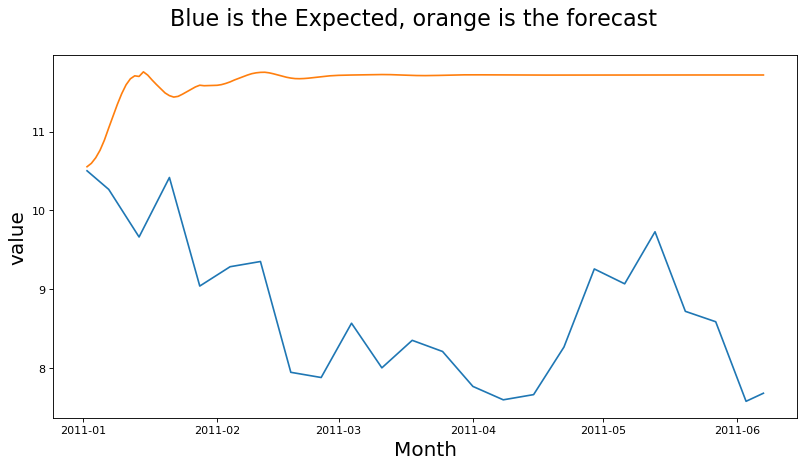

In [12]:
model_A_A = train_RNN(train_A_A,test_A_A, 24, 1, 800,'tanh',200)

## Model Training comparison
Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

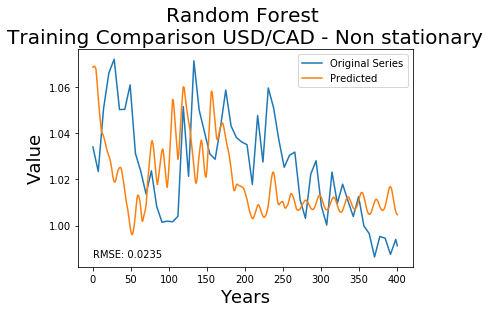


USD/CAD 12 step Forecast Errors
  Error     Value
0  MAPE  0.021102
1    ME -0.006239
2   MAE  0.021751
3   MPE -0.005666
4  RMSE  0.026752


In [65]:
import sklearn.metrics
train_USD_CAD,test_USD_CAD = train_test_split(USD_CAD_serie[:575],test_size = 0.30, shuffle =False)
train_USD_BRL,test_USD_BRL = train_test_split(USD_BRL_serie[:575],test_size = 0.30, shuffle =False)
train_A_A,test_A_A = train_test_split(AmericanAirlines_serie[:523],test_size = 0.30, shuffle =False)
scaler = MinMaxScaler()
scaler.fit(train_USD_CAD)
scaled_train_series = scaler.transform(train_USD_CAD)


test_predictions = []
    
first_eval_batch = scaled_train_series[:24]
current_batch = first_eval_batch.reshape((1, 24, 1))
    
for i in range(len(train_USD_CAD)):

        # get the prediction value for the first batch
    current_pred = model_USD_CAD.predict(current_batch)[0]

        # append the prediction into the array
    test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
#train_USD_CAD['prodict Adj close'] = true_predictions
#test_USD_CAD.plot(figsize=(14,5),)
#plot_series(train_USD_CAD,'Blue is the Expected, orange is the forecast','Month','value')
train_USD_CAD_y = train_USD_CAD['Adj Close'].values
true_predictions_y = true_predictions
plot_2_series(real=train_USD_CAD_y,
            model=true_predictions_y,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_CAD_y,true_predictions_y)),
            title='Random Forest \nTraining Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')
print("\nUSD/CAD 12 step Forecast Errors")
print(errors(train_USD_CAD_y,true_predictions_y))

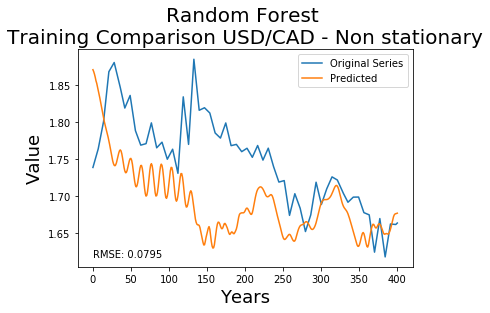


USD/BRL 12 step Forecast Errors
  Error     Value
0  MAPE  0.043811
1    ME -0.056221
2   MAE  0.077746
3   MPE -0.031013
4  RMSE  0.094498


In [64]:
scaler.fit(train_USD_BRL)
scaled_train_series = scaler.transform(train_USD_BRL)


test_predictions = []
    
first_eval_batch = scaled_train_series[:24]
current_batch = first_eval_batch.reshape((1, 24, 1))
    
for i in range(len(train_USD_BRL)):

        # get the prediction value for the first batch
    current_pred = model_USD_BRL.predict(current_batch)[0]

        # append the prediction into the array
    test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
#train_USD_CAD['prodict Adj close'] = true_predictions
#test_USD_CAD.plot(figsize=(14,5),)
#plot_series(train_USD_CAD,'Blue is the Expected, orange is the forecast','Month','value')
train_USD_BRL_y = train_USD_BRL['Adj Close'].values
true_predictions_y = true_predictions
plot_2_series(real=train_USD_BRL_y,
            model=true_predictions_y,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_BRL_y,true_predictions_y)),
            title='Random Forest \nTraining Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')
print("\nUSD/BRL 12 step Forecast Errors")
print(errors(train_USD_BRL_y,true_predictions_y))

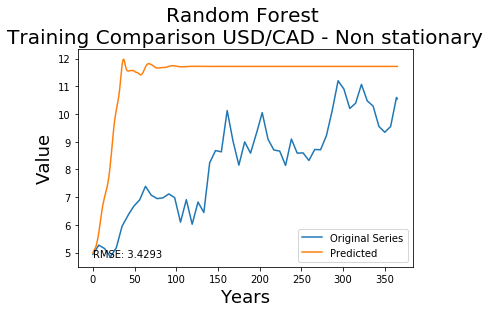


American 1 step Forecast Errors
  Error     Value
0  MAPE  0.470588
1    ME  3.100928
2   MAE  3.354350
3   MPE  0.443149
4  RMSE  3.760817


In [66]:
scaler.fit(train_A_A)
scaled_train_series = scaler.transform(train_A_A)


test_predictions = []
    
first_eval_batch = scaled_train_series[:24]
current_batch = first_eval_batch.reshape((1, 24, 1))
    
for i in range(len(train_A_A)):

        # get the prediction value for the first batch
    current_pred = model_A_A.predict(current_batch)[0]

        # append the prediction into the array
    test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
#train_USD_CAD['prodict Adj close'] = true_predictions
#test_USD_CAD.plot(figsize=(14,5),)
#plot_series(train_USD_CAD,'Blue is the Expected, orange is the forecast','Month','value')
train_A_A_y = train_A_A['Adj Close'].values
true_predictions_y = true_predictions
plot_2_series(real=train_A_A_y,
            model=true_predictions_y,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_A_A_y,true_predictions_y)),
            title='Random Forest \nTraining Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')
print("\nAmerican 1 step Forecast Errors")
print(errors(train_A_A_y,true_predictions_y))
